## Start

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna.visualization as vis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, learning_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("train_1.csv").drop(columns=['id'])
test = pd.read_csv("test_1.csv").drop(columns=['id'])

In [3]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,...,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,84.0,...,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,80.0,...,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,79.0,...,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,76.0,...,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  15000 non-null  float64
 1   height(cm)           15000 non-null  float64
 2   weight(kg)           15000 non-null  float64
 3   waist(cm)            15000 non-null  float64
 4   eyesight(left)       15000 non-null  float64
 5   eyesight(right)      15000 non-null  float64
 6   hearing(left)        15000 non-null  float64
 7   hearing(right)       15000 non-null  float64
 8   systolic             15000 non-null  float64
 9   relaxation           15000 non-null  float64
 10  fasting blood sugar  15000 non-null  float64
 11  Cholesterol          15000 non-null  float64
 12  triglyceride         15000 non-null  float64
 13  HDL                  15000 non-null  float64
 14  LDL                  15000 non-null  float64
 15  hemoglobin           15000 non-null 

In [5]:
train.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.659667,164.669333,64.235333,80.251100,1.034373,1.029453,1.005600,1.00600,119.219133,74.963667,...,57.374733,113.391200,14.505213,1.016067,0.866873,22.236600,20.859400,26.289933,0.145733,0.369133
std,10.514524,8.524211,10.999092,7.927326,0.304866,0.302373,0.074626,0.07723,11.151900,7.956559,...,11.436670,18.574279,1.398364,0.160656,0.165501,5.640184,10.310916,18.685708,0.352850,0.482586
min,20.000000,140.000000,40.000000,1.000000,0.100000,0.100000,1.000000,1.00000,84.000000,42.000000,...,28.000000,47.000000,7.300000,1.000000,0.100000,10.000000,5.000000,6.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,75.000000,0.900000,0.800000,1.000000,1.00000,110.000000,70.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.00000,119.000000,75.000000,...,56.000000,113.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.00000,128.000000,80.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,85.000000,190.000000,120.000000,117.000000,9.900000,9.900000,2.000000,2.00000,199.000000,122.000000,...,107.000000,202.000000,18.800000,5.000000,1.500000,87.000000,166.000000,439.000000,1.000000,1.000000


## Types

Чтобы упрастить обучение перевожу типы данных на более простые

In [6]:
train['smoking'] = train['smoking'].astype(bool)

In [7]:
columns = []

for i in test.columns.to_list():
    lst = []
    for j in test[i].to_list():
        if j != int(j):
            lst.append(j)
    if lst:
        print(f'"{i}" ustunida float qiymatlar soni: {len(lst)}')
    else:
        columns.append(i)
    lst.clear()

"waist(cm)" ustunida float qiymatlar soni: 1428
"eyesight(left)" ustunida float qiymatlar soni: 7424
"eyesight(right)" ustunida float qiymatlar soni: 7416
"hemoglobin" ustunida float qiymatlar soni: 9025
"serum creatinine" ustunida float qiymatlar soni: 8273


In [8]:
def func_1(df):
    for i in columns:
        df[i] = df[i].astype(int)
    return df

train = func_1(train)
test = func_1(test)

train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,170,80,92.0,1.2,0.8,1,1,129,74,...,49,114,15.4,1,0.9,20,23,13,0,False
1,30,170,80,94.0,1.5,1.5,1,1,128,84,...,51,111,16.2,1,0.9,30,39,92,0,True
2,45,170,75,84.0,1.0,1.0,1,1,124,80,...,52,112,14.6,2,0.9,20,20,50,0,True
3,55,150,55,85.0,0.9,0.5,1,1,123,79,...,61,119,13.4,1,0.8,25,20,18,0,False
4,45,160,55,72.0,0.5,0.6,1,1,117,76,...,61,120,13.9,1,0.7,20,26,10,0,False


In [9]:
for i in columns:
    print(f'{i} {len(test[i].unique())}')

age 13
height(cm) 11
weight(kg) 19
hearing(left) 2
hearing(right) 2
systolic 74
relaxation 60
fasting blood sugar 101
Cholesterol 140
triglyceride 308
HDL 74
LDL 135
Urine protein 5
AST 59
ALT 93
Gtp 148
dental caries 2


Можно перевести 3 признака в bool

In [10]:
train['hearing(left)'] = train['hearing(left)'].astype(bool)
train['hearing(right)'] = train['hearing(right)'].astype(bool)
train['dental caries'] = train['dental caries'].astype(bool)

test['hearing(left)'] = test['hearing(left)'].astype(bool)
test['hearing(right)'] = test['hearing(right)'].astype(bool)
test['dental caries'] = test['dental caries'].astype(bool)

## WoE

### функции

In [11]:
def WoE(data, feature_name):
    df = data.copy()
    
    woe_table = df.groupby(feature_name)['smoking'].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    
    woe_table['Percentage events'] = woe_table['# of events'] / woe_table['# of events'].sum()
    woe_table['Percentage non-events'] = woe_table['# of non-events'] / woe_table['# of non-events'].sum()
    
    woe_table['WoE'] = np.log(woe_table['Percentage events'] / woe_table['Percentage non-events'])
    
    woe_table['Total Observations'] = woe_table['# of events'] + woe_table['# of non-events']
    woe_table['Percent of Observations'] = (woe_table['Total Observations'] / woe_table['Total Observations'].sum() * 100).round(3)

    return woe_table.reset_index()

In [12]:
def print_WoE(df_woe, col, rotation=45):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    sns.pointplot(data=df_woe, x=col, y='WoE', color='red', linewidth=2, ax=ax1)
    ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
    ax1.tick_params(axis='y', colors='red')
    ax1.set_xlabel(col)

    ax1.grid(visible=True, which='major', linestyle='--')

    sns.barplot(data=df_woe, x=col, y='Percent of Observations', alpha=0.3, ax=ax2)
    ax2.set_ylabel('Rate of Observations')
    ax2.set_ylim(0, df_woe['Percent of Observations'].max() * 1.2)
    ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)

    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=rotation)

    plt.show()

### признаки

#### age

In [13]:
col = 'age'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins=10)
df_woe = WoE(train, colcat)
df_woe

smoking,age_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(19.935, 26.5]",601,664,0.119921,0.063511,0.635624,1265,8.433
1,"(26.5, 33.0]",524,540,0.097526,0.055374,0.566014,1064,7.093
2,"(33.0, 39.5]",469,714,0.128951,0.049561,0.956217,1183,7.887
3,"(39.5, 46.0]",4787,2515,0.454217,0.505865,-0.107694,7302,48.680
4,"(46.0, 52.5]",934,411,0.074228,0.098700,-0.284947,1345,8.967
5,"(52.5, 59.0]",796,256,0.046234,0.084117,-0.598485,1052,7.013
6,"(59.0, 65.5]",1215,414,0.074770,0.128395,-0.540697,1629,10.860
7,"(65.5, 72.0]",70,16,0.002890,0.007397,-0.939970,86,0.573
8,"(72.0, 78.5]",50,5,0.000903,0.005284,-1.766648,55,0.367
9,"(78.5, 85.0]",17,2,0.000361,0.001796,-1.604130,19,0.127


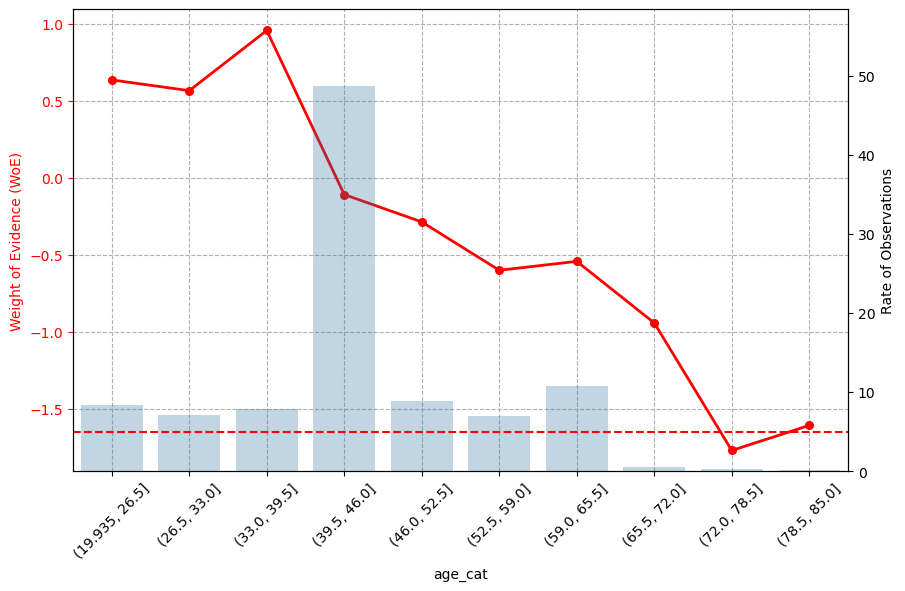

In [14]:
print_WoE(df_woe, colcat)

In [15]:
bins = [0, 33, 44, 49, 59, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,age_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 33.0]",1125,1204,0.217446,0.118884,0.603803,2329,15.527
1,"(33.0, 44.0]",4010,2650,0.478599,0.423756,0.121705,6660,44.400
2,"(44.0, 49.0]",1246,579,0.104569,0.131671,-0.230455,1825,12.167
3,"(49.0, 59.0]",1730,667,0.120462,0.182817,-0.417150,2397,15.980
4,"(59.0, inf]",1352,437,0.078924,0.142872,-0.593470,1789,11.927


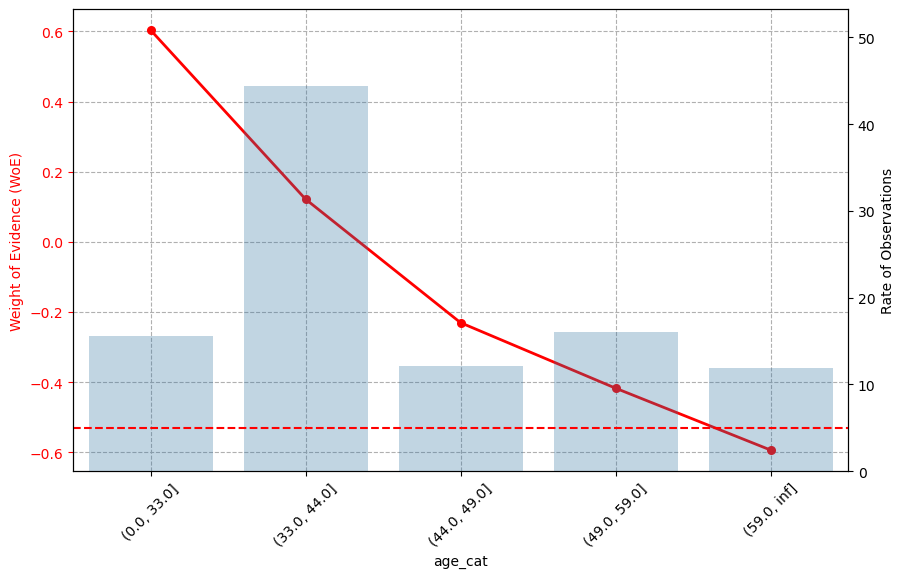

In [16]:
print_WoE(df_woe, colcat)

In [17]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### height(cm)

In [18]:
col = 'height(cm)'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins=10)
df_woe = WoE(train, colcat)
df_woe

smoking,height(cm)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(139.95, 145.0]",149,0,0.000000,0.015746,-inf,149,0.993
1,"(145.0, 150.0]",1059,20,0.003612,0.111910,-3.433411,1079,7.193
2,"(150.0, 155.0]",2329,83,0.014990,0.246116,-2.798417,2412,16.080
3,"(155.0, 160.0]",2094,316,0.057071,0.221283,-1.355153,2410,16.067
4,"(160.0, 165.0]",1415,1230,0.222142,0.149530,0.395821,2645,17.633
5,"(165.0, 170.0]",1306,2002,0.361568,0.138011,0.963114,3308,22.053
6,"(170.0, 175.0]",857,1459,0.263500,0.090563,1.068005,2316,15.440
7,"(175.0, 180.0]",224,356,0.064295,0.023671,0.999221,580,3.867
8,"(180.0, 185.0]",30,70,0.012642,0.003170,1.383234,100,0.667
9,"(185.0, 190.0]",0,1,0.000181,0.000000,inf,1,0.007


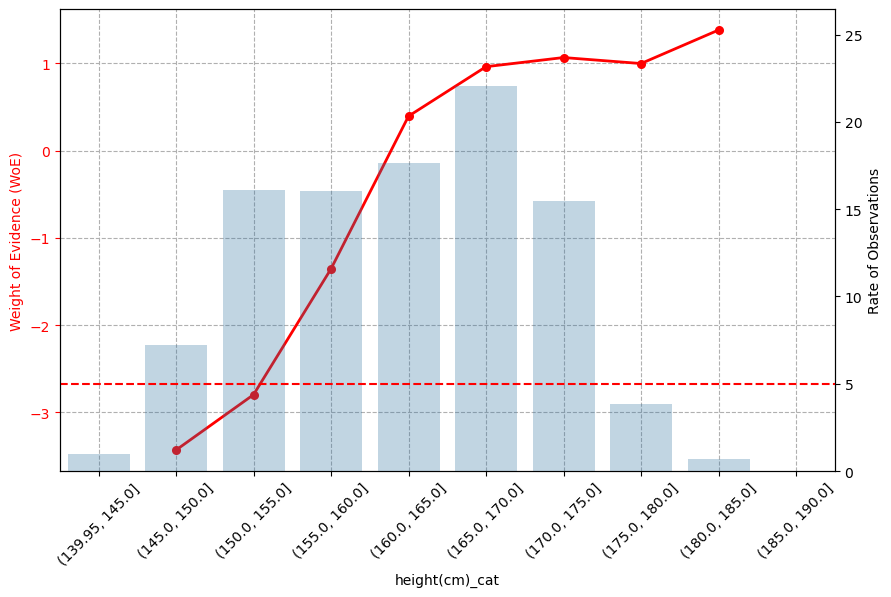

In [19]:
print_WoE(df_woe, colcat)

In [20]:
bins = [0, 150, 155, 160, 165, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,height(cm)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 150.0]",1208,20,0.003612,0.127655,-3.565052,1228,8.187
1,"(150.0, 155.0]",2329,83,0.014990,0.246116,-2.798417,2412,16.080
2,"(155.0, 160.0]",2094,316,0.057071,0.221283,-1.355153,2410,16.067
3,"(160.0, 165.0]",1415,1230,0.222142,0.149530,0.395821,2645,17.633
4,"(165.0, inf]",2417,3888,0.702185,0.255416,1.011304,6305,42.033


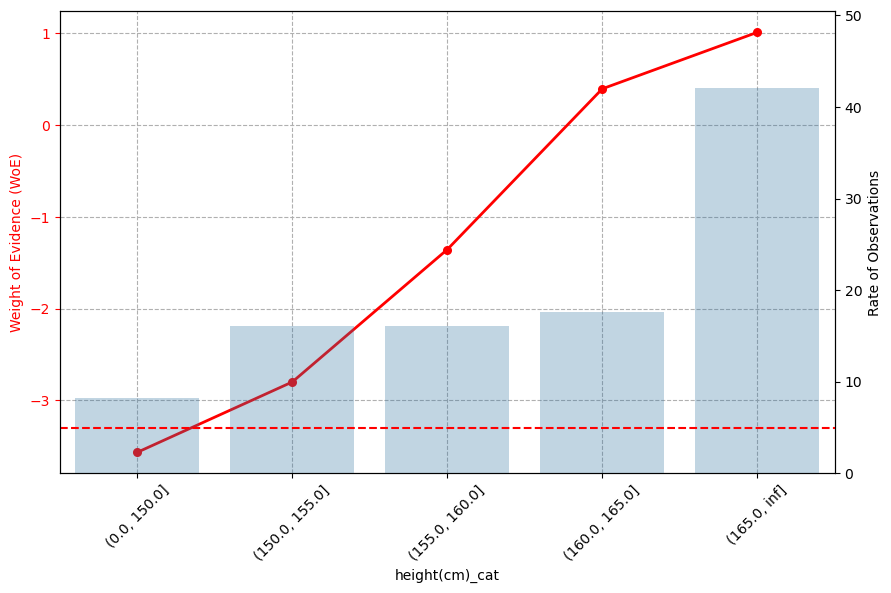

In [21]:
print_WoE(df_woe, colcat)

In [22]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### weight(kg)

In [23]:
col = 'weight(kg)'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins=10)
df_woe = WoE(train, colcat)
df_woe

smoking,weight(kg)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(39.92, 48.0]",590,16,0.002890,0.062348,-3.071597,606,4.040
1,"(48.0, 56.0]",3431,464,0.083800,0.362570,-1.464786,3895,25.967
2,"(56.0, 64.0]",1736,666,0.120282,0.183451,-0.422113,2402,16.013
3,"(64.0, 72.0]",2437,2380,0.429836,0.257529,0.512269,4817,32.113
4,"(72.0, 80.0]",958,1476,0.266570,0.101236,0.968180,2434,16.227
5,"(80.0, 88.0]",175,316,0.057071,0.018493,1.126893,491,3.273
6,"(88.0, 96.0]",121,175,0.031606,0.012787,0.904932,296,1.973
7,"(96.0, 104.0]",8,29,0.005237,0.000845,1.823791,37,0.247
8,"(104.0, 112.0]",7,14,0.002528,0.000740,1.229084,21,0.140
9,"(112.0, 120.0]",0,1,0.000181,0.000000,inf,1,0.007


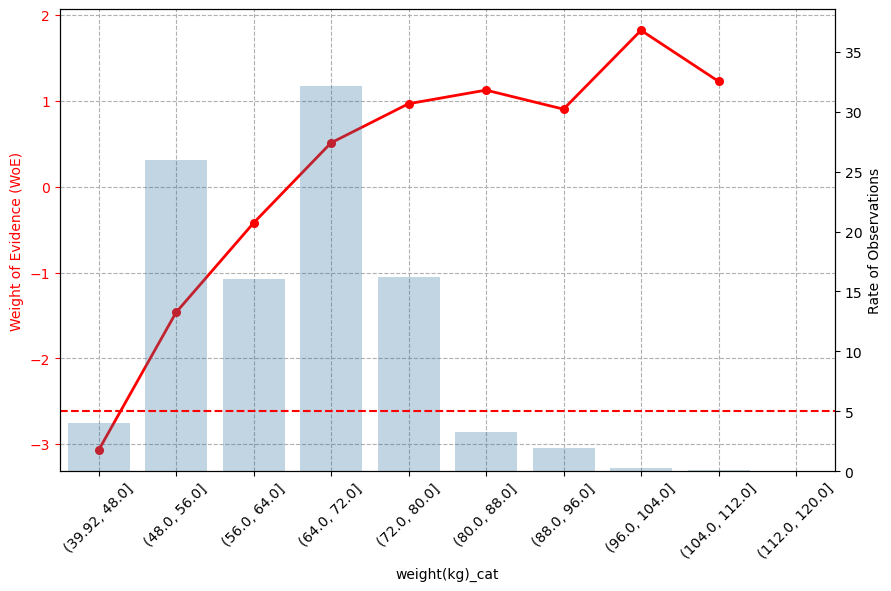

In [24]:
print_WoE(df_woe, colcat)

In [25]:
bins = [0, 50, 56, 64, 72, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,weight(kg)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 50.0]",2151,136,0.024562,0.227306,-2.225097,2287,15.247
1,"(50.0, 56.0]",1870,344,0.062128,0.197612,-1.157115,2214,14.760
2,"(56.0, 64.0]",1736,666,0.120282,0.183451,-0.422113,2402,16.013
3,"(64.0, 72.0]",2437,2380,0.429836,0.257529,0.512269,4817,32.113
4,"(72.0, inf]",1269,2011,0.363193,0.134101,0.996340,3280,21.867


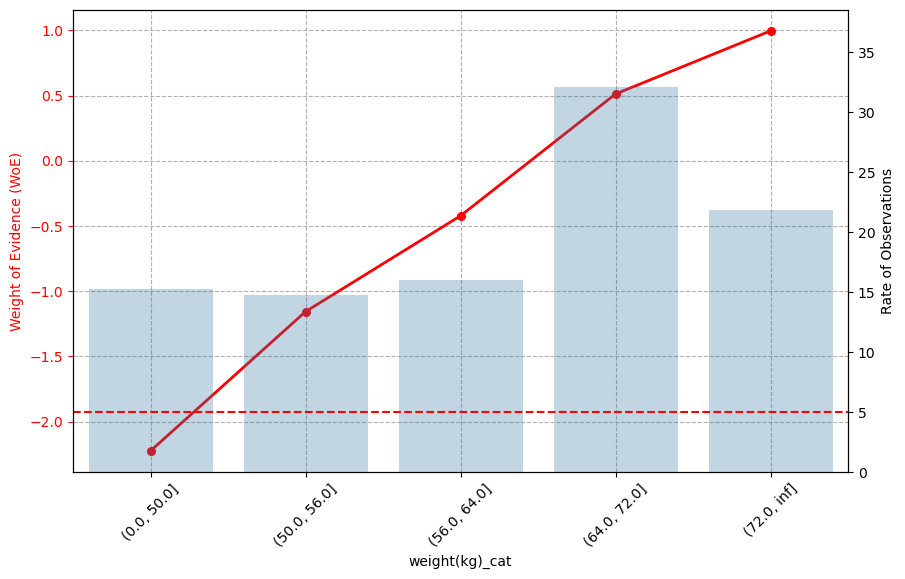

In [26]:
print_WoE(df_woe, colcat)

In [27]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### waist(cm)

In [28]:
col = 'waist(cm)'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins=10)
df_woe = WoE(train, colcat)
df_woe

smoking,waist(cm)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.884, 12.6]",0,1,0.000181,0.000000,inf,1,0.007
1,"(12.6, 24.2]",0,0,0.000000,0.000000,NaN,0,0.000
2,"(24.2, 35.8]",0,0,0.000000,0.000000,NaN,0,0.000
3,"(35.8, 47.4]",0,0,0.000000,0.000000,NaN,0,0.000
4,"(47.4, 59.0]",16,1,0.000181,0.001691,-2.236652,17,0.113
5,"(59.0, 70.6]",1604,160,0.028897,0.169502,-1.769145,1764,11.760
6,"(70.6, 82.2]",5010,2390,0.431642,0.529430,-0.204206,7400,49.333
7,"(82.2, 93.8]",2521,2571,0.464331,0.266406,0.555576,5092,33.947
8,"(93.8, 105.4]",302,402,0.072602,0.031914,0.821962,704,4.693
9,"(105.4, 117.0]",10,12,0.002167,0.001057,0.718258,22,0.147


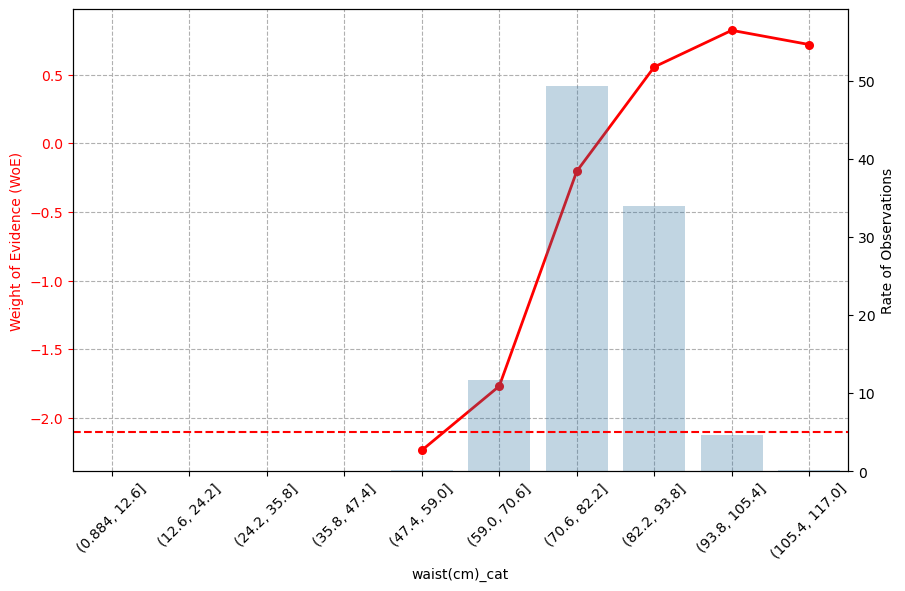

In [29]:
print_WoE(df_woe, colcat)

In [30]:
bins=[0, 70, 80, 92, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,waist(cm)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 70.0]",1589,159,0.028716,0.167917,-1.766019,1748,11.653
1,"(70.0, 80.0]",4185,1722,0.310999,0.442249,-0.352084,5907,39.380
2,"(80.0, 92.0]",3298,3135,0.566191,0.348515,0.485250,6433,42.887
3,"(92.0, inf]",391,521,0.094094,0.041319,0.822979,912,6.080


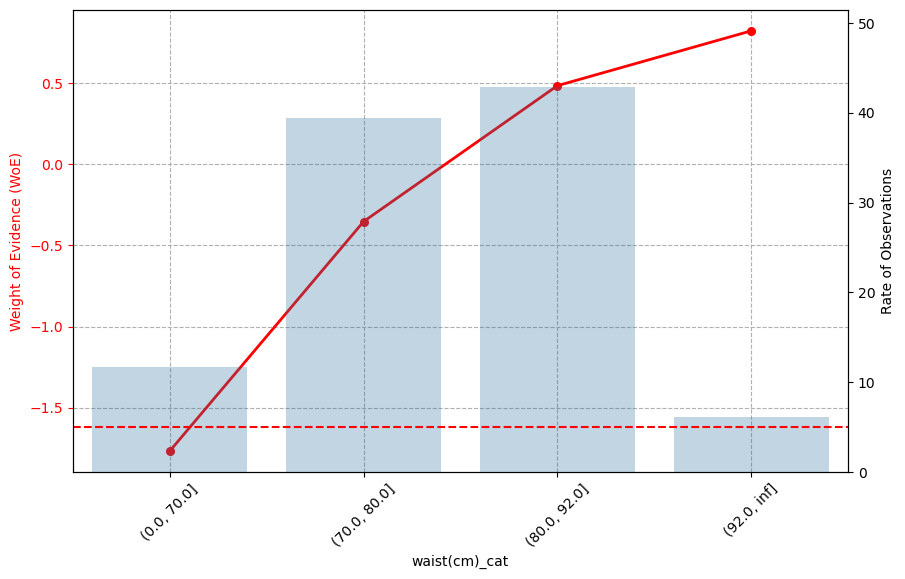

In [31]:
print_WoE(df_woe, colcat)

In [32]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### eyesight(left)

In [33]:
col = 'eyesight(left)'
colcat = col + '_cat'

train[colcat] = pd.qcut(train[col], q=4)
df_woe = WoE(train, colcat)
df_woe

smoking,eyesight(left)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.099, 0.9]",3642,1487,0.268557,0.384867,-0.359836,5129,34.193
1,"(0.9, 1.0]",2376,1454,0.262597,0.251083,0.044837,3830,25.533
2,"(1.0, 1.2]",2287,1521,0.274697,0.241678,0.128064,3808,25.387
3,"(1.2, 9.9]",1158,1075,0.194148,0.122371,0.461563,2233,14.887


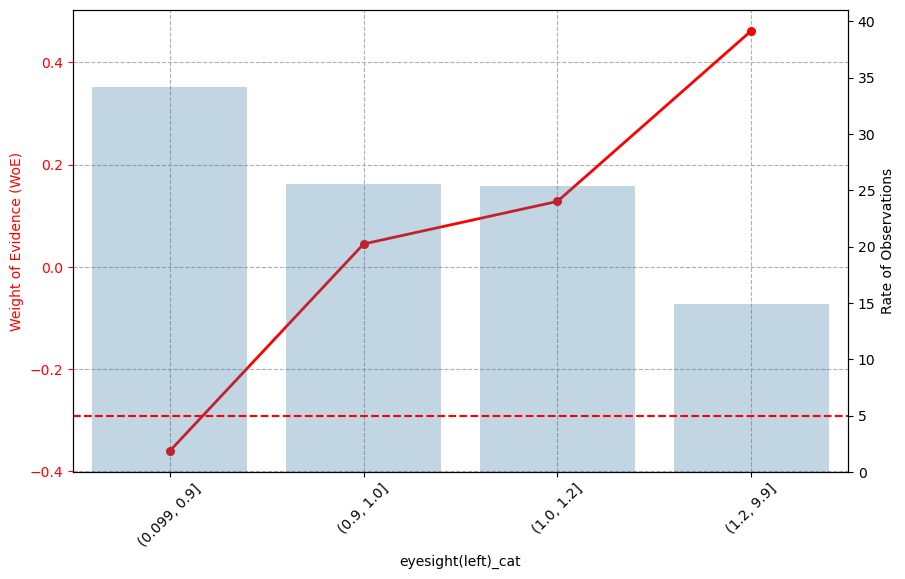

In [34]:
print_WoE(df_woe, colcat)

In [35]:
bins = [0, 0.9, 1.2, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,eyesight(left)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 0.9]",3642,1487,0.268557,0.384867,-0.359836,5129,34.193
1,"(0.9, 1.2]",4663,2975,0.537295,0.492761,0.086522,7638,50.920
2,"(1.2, inf]",1158,1075,0.194148,0.122371,0.461563,2233,14.887


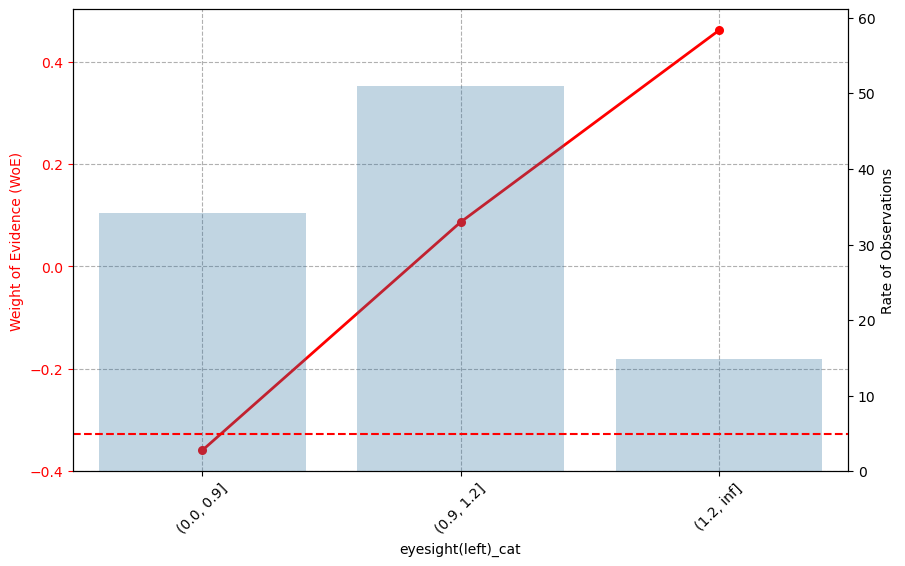

In [36]:
print_WoE(df_woe, colcat)

In [37]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### eyesight(right)

In [38]:
col = 'eyesight(right)'
colcat = col + '_cat'

train[colcat] = pd.qcut(train[col], q=4)
df_woe = WoE(train, colcat)
df_woe

smoking,eyesight(right)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.099, 0.8]",2765,1030,0.186021,0.292191,-0.451545,3795,25.300
1,"(0.8, 1.0]",3312,1894,0.342062,0.349995,-0.022925,5206,34.707
2,"(1.0, 1.2]",2339,1563,0.282283,0.247173,0.132820,3902,26.013
3,"(1.2, 9.9]",1047,1050,0.189633,0.110641,0.538798,2097,13.980


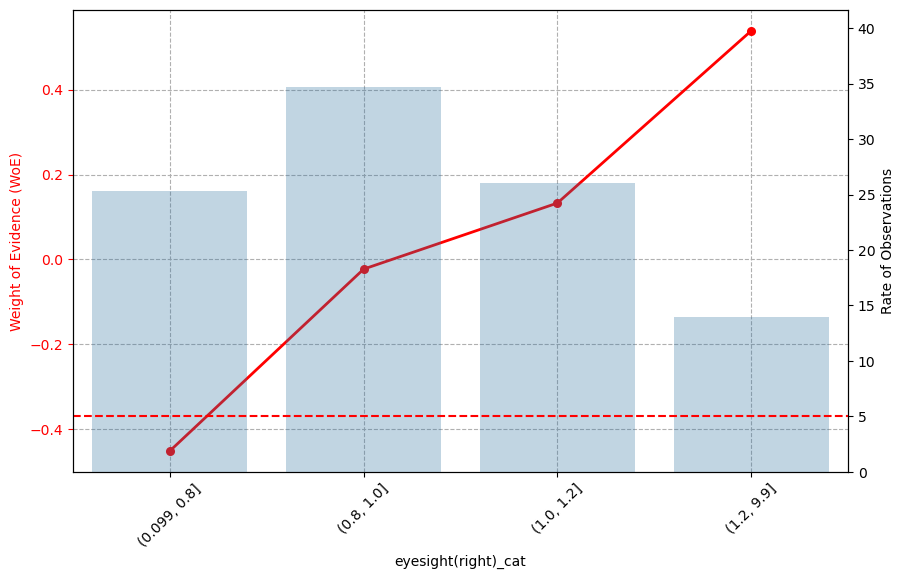

In [39]:
print_WoE(df_woe, colcat)

In [40]:
bins = [0, 0.9, 1.2, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,eyesight(right)_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 0.9]",3691,1517,0.273975,0.390045,-0.353226,5208,34.72
1,"(0.9, 1.2]",4725,2970,0.536392,0.499313,0.071631,7695,51.30
2,"(1.2, inf]",1047,1050,0.189633,0.110641,0.538798,2097,13.98


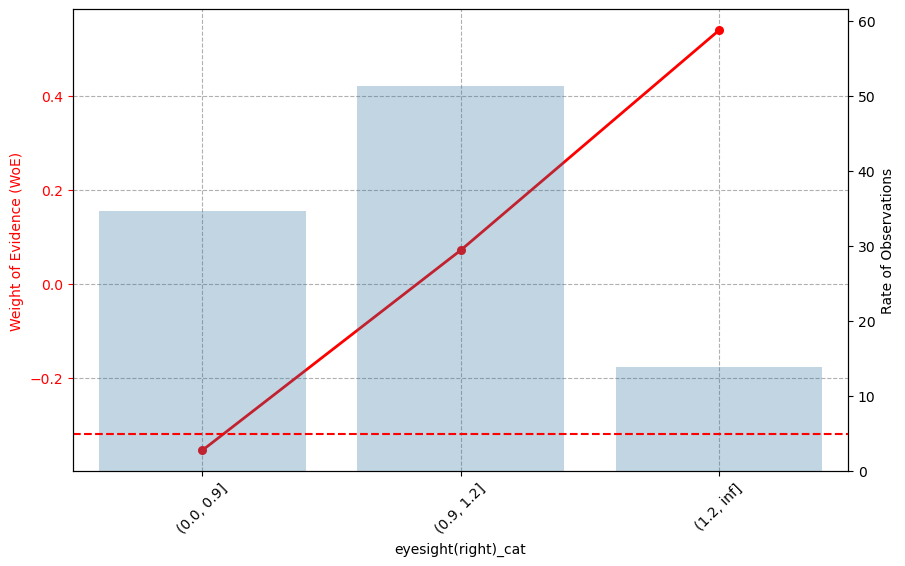

In [41]:
print_WoE(df_woe, colcat)

In [42]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### systolic

In [43]:
col = 'systolic'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 10)
df_woe = WoE(train, colcat)
df_woe

smoking,systolic_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(83.885, 95.5]",155,11,0.001987,0.016380,-2.109593,166,1.107
1,"(95.5, 107.0]",1367,418,0.075492,0.144457,-0.648956,1785,11.900
2,"(107.0, 118.5]",3427,1920,0.346758,0.362147,-0.043423,5347,35.647
3,"(118.5, 130.0]",3260,2280,0.411775,0.344500,0.178385,5540,36.933
4,"(130.0, 141.5]",1087,815,0.147192,0.114868,0.247948,1902,12.680
5,"(141.5, 153.0]",148,85,0.015351,0.015640,-0.018624,233,1.553
6,"(153.0, 164.5]",16,6,0.001084,0.001691,-0.444893,22,0.147
7,"(164.5, 176.0]",3,1,0.000181,0.000317,-0.562676,4,0.027
8,"(176.0, 187.5]",0,0,0.000000,0.000000,NaN,0,0.000
9,"(187.5, 199.0]",0,1,0.000181,0.000000,inf,1,0.007


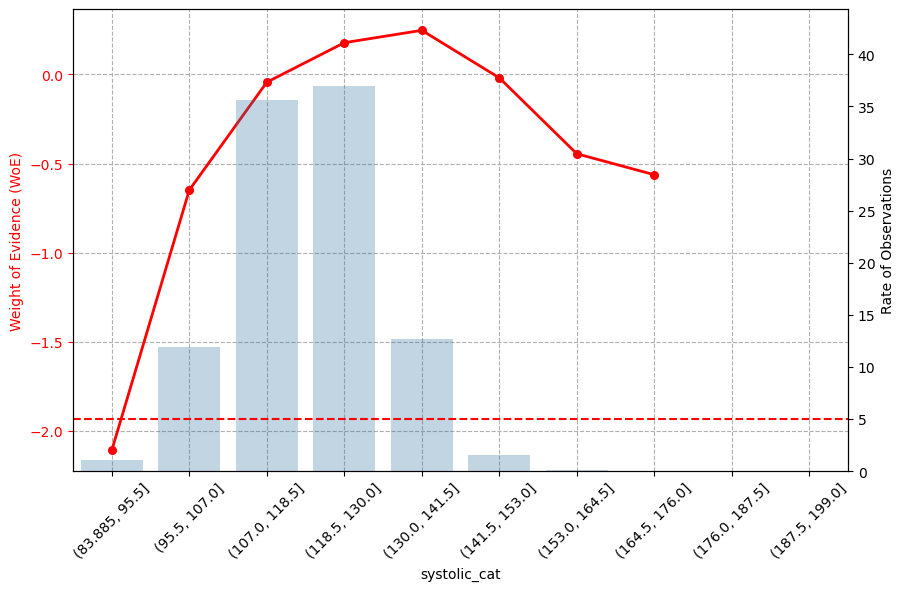

In [44]:
print_WoE(df_woe, colcat)

In [45]:
bins = [0, 100, 110, 120, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,systolic_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 100.0]",704,167,0.030161,0.074395,-0.902848,871,5.807
1,"(100.0, 110.0]",2032,984,0.177714,0.214731,-0.189213,3016,20.107
2,"(110.0, 120.0]",3234,1844,0.333032,0.341752,-0.025846,5078,33.853
3,"(120.0, inf]",3493,2542,0.459093,0.369122,0.218127,6035,40.233


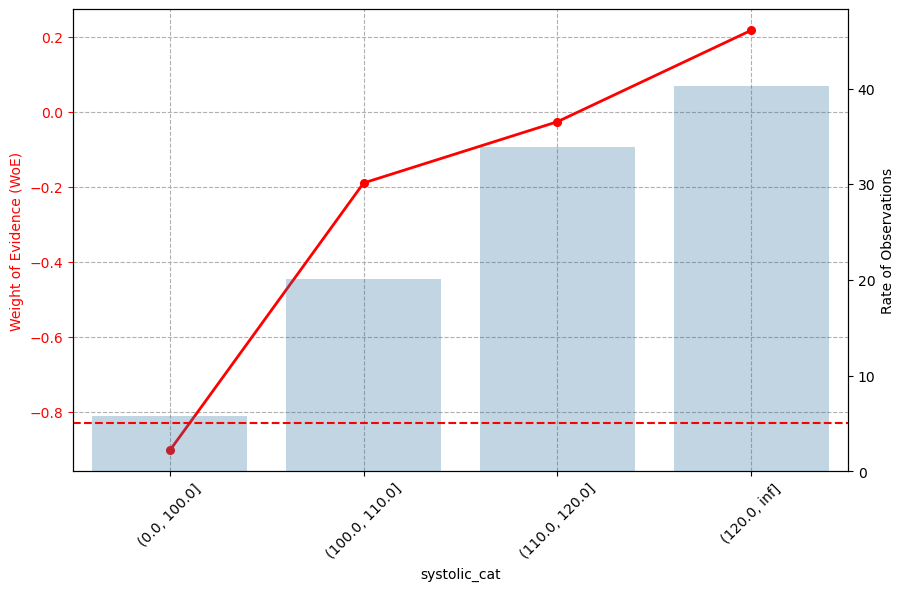

In [46]:
print_WoE(df_woe, colcat)

In [47]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### relaxation

In [48]:
col = 'relaxation'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 15)
df_woe = WoE(train, colcat)
df_woe

smoking,relaxation_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(41.92, 47.333]",1,0,0.000000,0.000106,-inf,1,0.007
1,"(47.333, 52.667]",5,1,0.000181,0.000528,-1.073501,6,0.040
2,"(52.667, 58.0]",89,21,0.003793,0.009405,-0.908177,110,0.733
3,"(58.0, 63.333]",934,252,0.045512,0.098700,-0.774111,1186,7.907
4,"(63.333, 68.667]",1236,365,0.065920,0.130614,-0.683802,1601,10.673
5,"(68.667, 74.0]",2647,1507,0.272169,0.279721,-0.027369,4154,27.693
6,"(74.0, 79.333]",1862,1193,0.215460,0.196766,0.090757,3055,20.367
7,"(79.333, 84.667]",1784,1436,0.259346,0.188524,0.318940,3220,21.467
8,"(84.667, 90.0]",779,660,0.119198,0.082321,0.370165,1439,9.593
9,"(90.0, 95.333]",65,47,0.008488,0.006869,0.211697,112,0.747


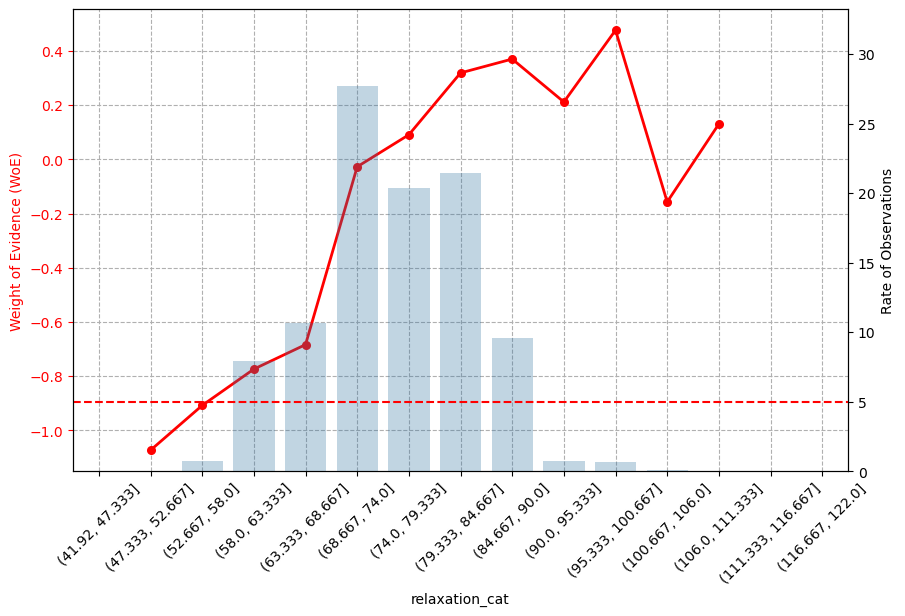

In [49]:
print_WoE(df_woe, colcat)

In [50]:
bins = [0, 68, 74, 85, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,relaxation_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 68.0]",2265,639,0.115405,0.239353,-0.729489,2904,19.360
1,"(68.0, 74.0]",2647,1507,0.272169,0.279721,-0.027369,4154,27.693
2,"(74.0, 85.0]",3776,2745,0.495756,0.399028,0.217052,6521,43.473
3,"(85.0, inf]",775,646,0.116670,0.081898,0.353873,1421,9.473


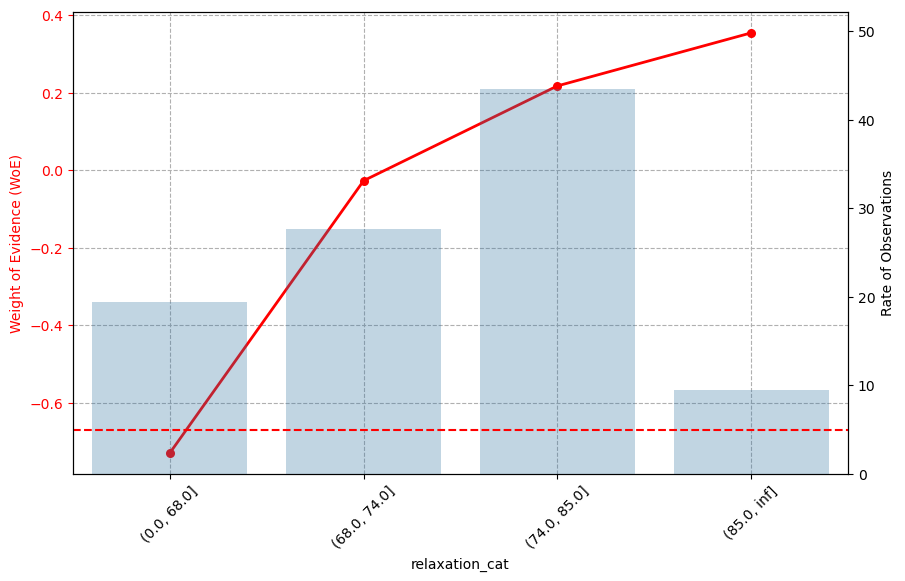

In [51]:
print_WoE(df_woe, colcat)

In [52]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### fasting blood sugar

In [53]:
col = 'fasting blood sugar'
colcat = col + '_cat'

train[colcat] = pd.qcut(train[col], q = 4)
df_woe = WoE(train, colcat)
df_woe

smoking,fasting blood sugar_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(50.999, 89.0]",2889,1291,0.233159,0.305294,-0.269557,4180,27.867
1,"(89.0, 94.0]",2375,1311,0.236771,0.250977,-0.058271,3686,24.573
2,"(94.0, 100.0]",2364,1388,0.250677,0.249815,0.003445,3752,25.013
3,"(100.0, 369.0]",1835,1547,0.279393,0.193913,0.365210,3382,22.547


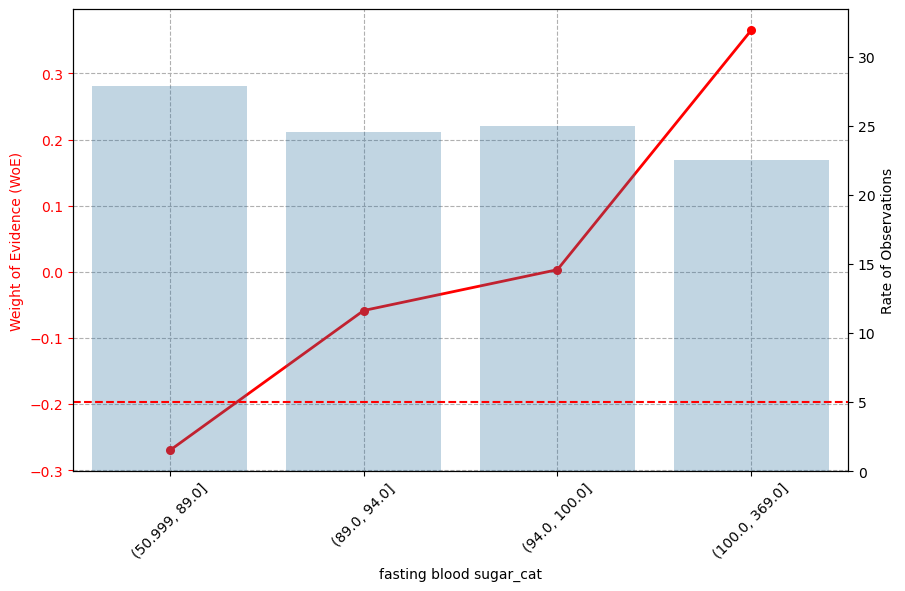

In [54]:
print_WoE(df_woe, colcat)

In [55]:
bins=[0, 89, 98, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,fasting blood sugar_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 89.0]",2889,1291,0.233159,0.305294,-0.269557,4180,27.867
1,"(89.0, 98.0]",4157,2321,0.419180,0.439290,-0.046859,6478,43.187
2,"(98.0, inf]",2417,1925,0.347661,0.255416,0.308335,4342,28.947


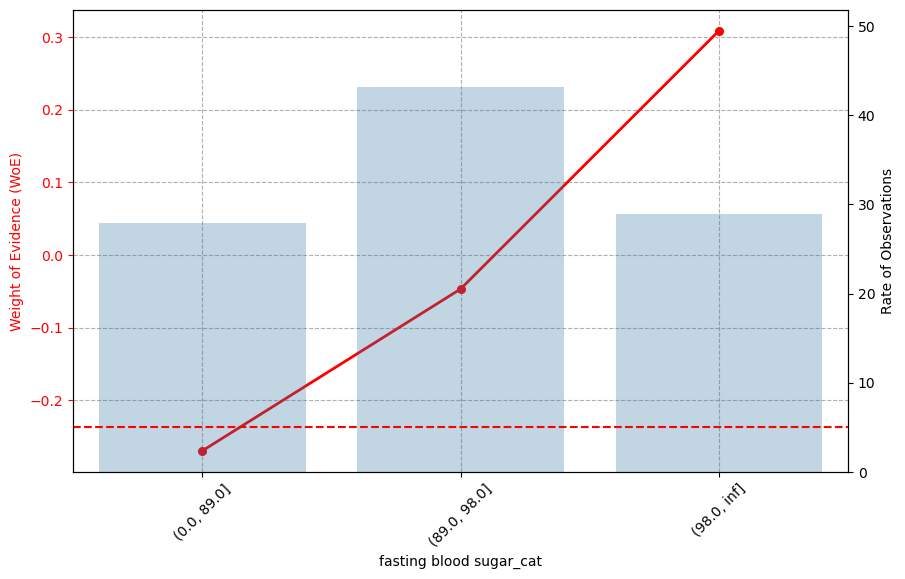

In [56]:
print_WoE(df_woe, colcat)

In [57]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### Cholesterol

In [58]:
col = 'Cholesterol'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 10)
df_woe = WoE(train, colcat)
df_woe

smoking,Cholesterol_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(107.813, 126.7]",7,1,0.000181,0.000740,-1.409974,8,0.053
1,"(126.7, 145.4]",49,47,0.008488,0.005178,0.494264,96,0.640
2,"(145.4, 164.1]",689,527,0.095178,0.072810,0.267896,1216,8.107
3,"(164.1, 182.8]",2540,1522,0.274878,0.268414,0.023798,4062,27.080
4,"(182.8, 201.5]",3246,1787,0.322738,0.343020,-0.060949,5033,33.553
5,"(201.5, 220.2]",2198,1246,0.225032,0.232273,-0.031673,3444,22.960
6,"(220.2, 238.9]",574,340,0.061405,0.060657,0.012253,914,6.093
7,"(238.9, 257.6]",130,59,0.010656,0.013738,-0.254060,189,1.260
8,"(257.6, 276.3]",30,7,0.001264,0.003170,-0.919351,37,0.247
9,"(276.3, 295.0]",0,1,0.000181,0.000000,inf,1,0.007


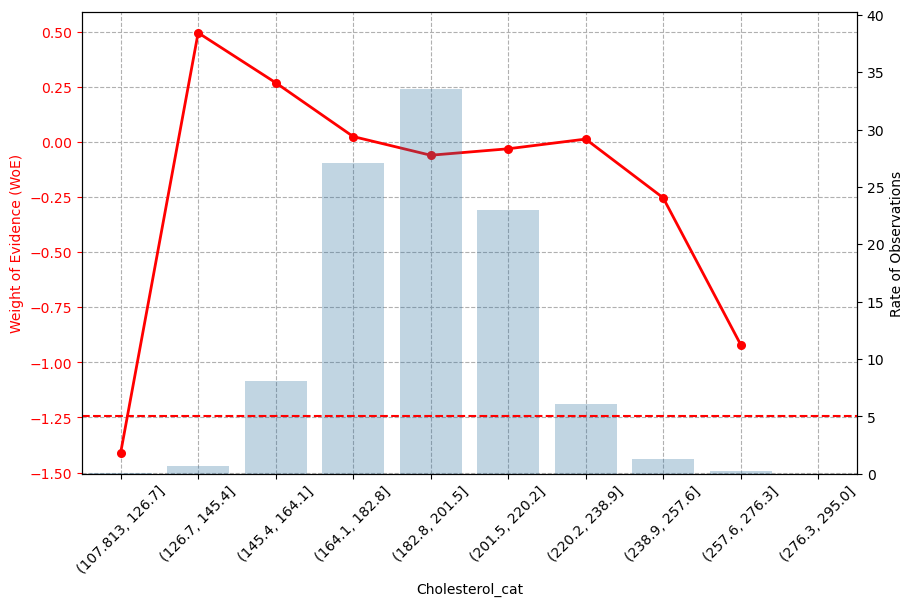

In [59]:
print_WoE(df_woe, colcat)

In [60]:
bins=[0, 165, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,Cholesterol_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 165.0]",806,643,0.116128,0.085174,0.309998,1449,9.66
1,"(165.0, inf]",8657,4894,0.883872,0.914826,-0.034422,13551,90.34


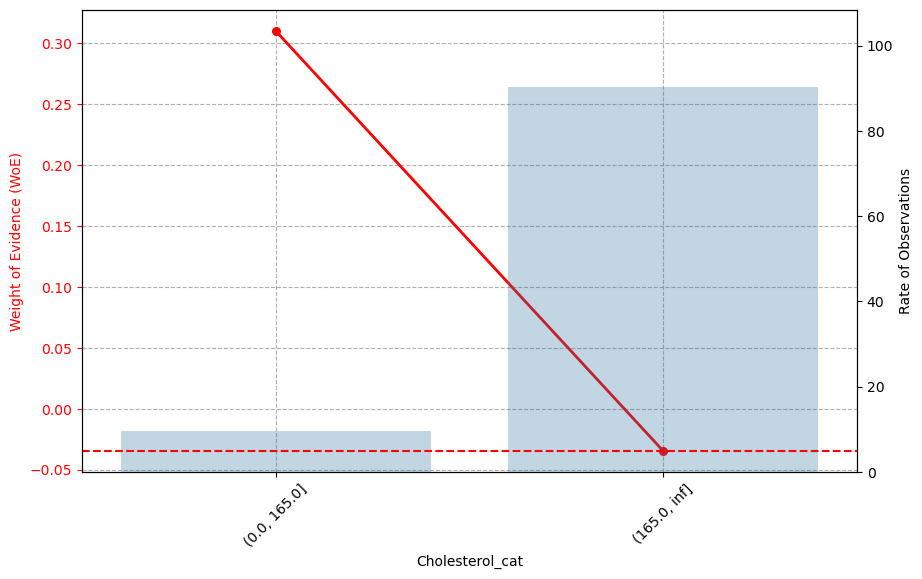

In [61]:
print_WoE(df_woe, colcat)

In [62]:
train[colcat] = train[col] > 165
test[colcat] = test[col] > 165

#### triglyceride

In [63]:
col = 'triglyceride'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 10)
df_woe = WoE(train, colcat)
df_woe

smoking,triglyceride_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(21.623, 59.7]",1744,229,0.041358,0.184297,-1.494278,1973,13.153
1,"(59.7, 97.4]",4834,1825,0.329601,0.510832,-0.438158,6659,44.393
2,"(97.4, 135.1]",2006,1848,0.333755,0.211984,0.453898,3854,25.693
3,"(135.1, 172.8]",508,777,0.140329,0.053683,0.960896,1285,8.567
4,"(172.8, 210.5]",220,411,0.074228,0.023248,1.160902,631,4.207
5,"(210.5, 248.2]",88,267,0.048221,0.009299,1.645848,355,2.367
6,"(248.2, 285.9]",41,86,0.015532,0.004333,1.276712,127,0.847
7,"(285.9, 323.6]",11,45,0.008127,0.001162,1.944704,56,0.373
8,"(323.6, 361.3]",9,30,0.005418,0.000951,1.739909,39,0.260
9,"(361.3, 399.0]",2,19,0.003431,0.000211,2.787228,21,0.140


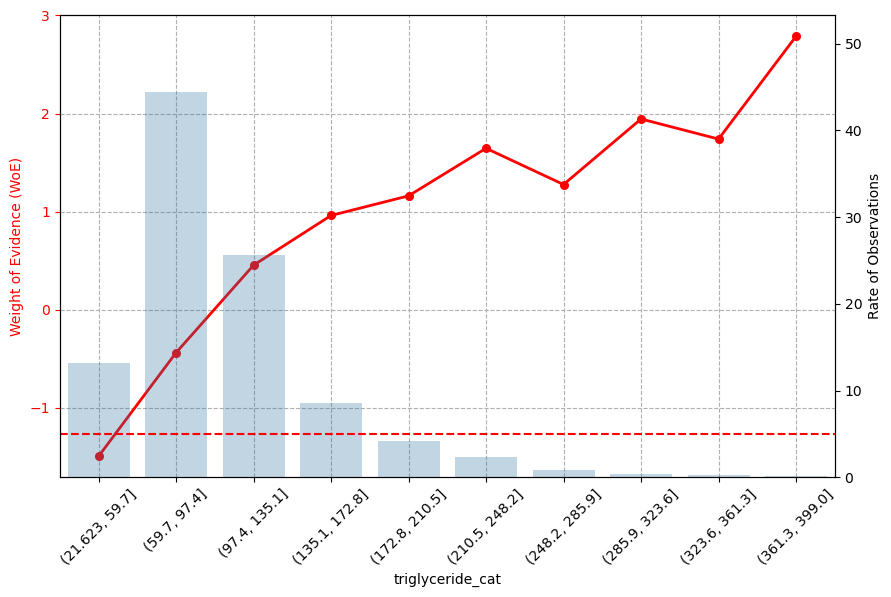

In [64]:
print_WoE(df_woe, colcat)

In [65]:
bins=[0, 60, 100, 135, 172, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,triglyceride_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 60.0]",1834,259,0.046776,0.193807,-1.421490,2093,13.953
1,"(60.0, 100.0]",4942,1951,0.352357,0.522245,-0.393491,6893,45.953
2,"(100.0, 135.0]",1808,1692,0.305581,0.191060,0.469627,3500,23.333
3,"(135.0, 172.0]",508,777,0.140329,0.053683,0.960896,1285,8.567
4,"(172.0, inf]",371,858,0.154958,0.039205,1.374339,1229,8.193


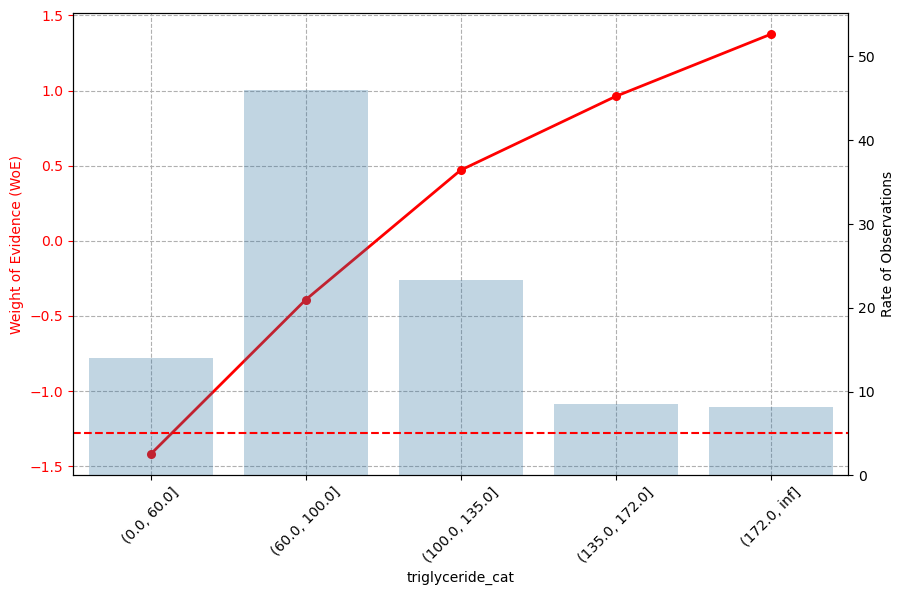

In [66]:
print_WoE(df_woe, colcat)

In [67]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### HDL

In [68]:
col = 'HDL'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 10)
df_woe = WoE(train, colcat)
df_woe

smoking,HDL_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(27.921, 35.9]",31,89,0.016074,0.003276,1.590586,120,0.800
1,"(35.9, 43.8]",570,851,0.153693,0.060235,0.936712,1421,9.473
2,"(43.8, 51.7]",1704,1768,0.319306,0.180070,0.572807,3472,23.147
3,"(51.7, 59.6]",2520,1538,0.277768,0.266300,0.042161,4058,27.053
4,"(59.6, 67.5]",2351,775,0.139967,0.248441,-0.573796,3126,20.840
5,"(67.5, 75.4]",1383,357,0.064475,0.146148,-0.818338,1740,11.600
6,"(75.4, 83.3]",641,116,0.020950,0.067738,-1.173503,757,5.047
7,"(83.3, 91.2]",209,34,0.006141,0.022086,-1.280037,243,1.620
8,"(91.2, 99.1]",50,8,0.001445,0.005284,-1.296645,58,0.387
9,"(99.1, 107.0]",4,1,0.000181,0.000423,-0.850358,5,0.033


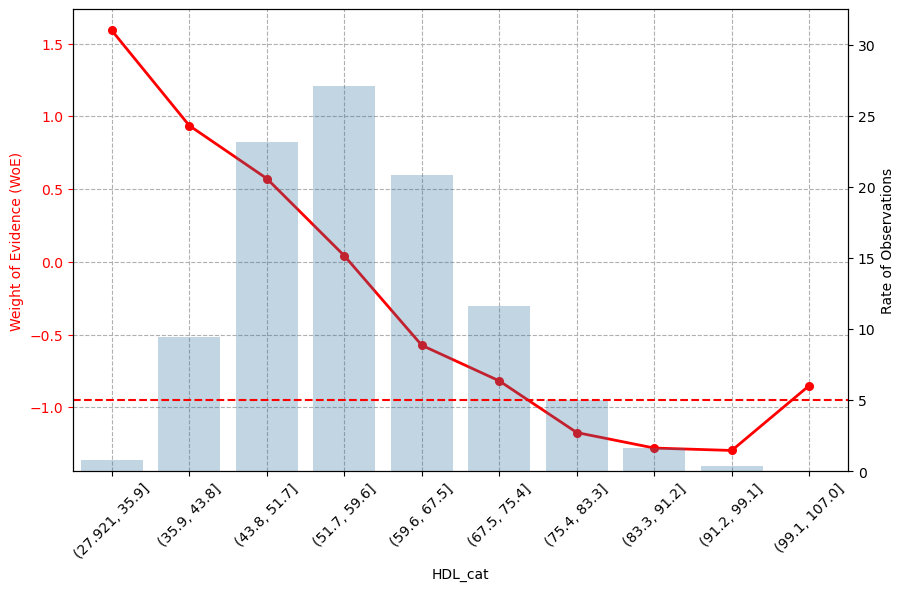

In [69]:
print_WoE(df_woe, colcat)

In [70]:
bins=[0, 42, 50, 60, 67, 75, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,HDL_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 42.0]",450,799,0.144302,0.047554,1.110050,1249,8.327
1,"(42.0, 50.0]",1559,1705,0.307928,0.164747,0.625457,3264,21.760
2,"(50.0, 60.0]",3178,1863,0.336464,0.335834,0.001873,5041,33.607
3,"(60.0, 67.0]",1989,654,0.118115,0.210187,-0.576343,2643,17.620
4,"(67.0, 75.0]",1383,357,0.064475,0.146148,-0.818338,1740,11.600
5,"(75.0, inf]",904,159,0.028716,0.095530,-1.201989,1063,7.087


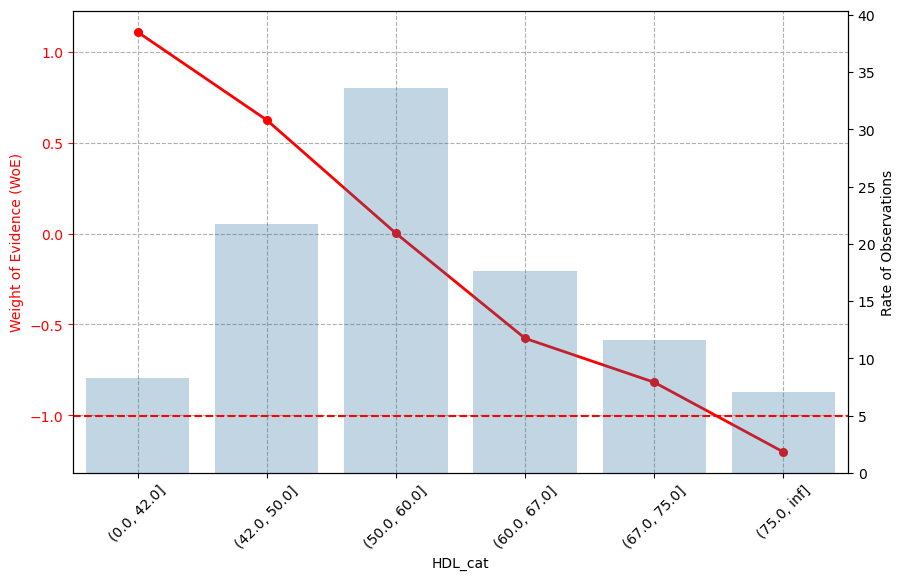

In [71]:
print_WoE(df_woe, colcat)

In [72]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### LDL

In [73]:
col = 'LDL'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 10)
df_woe = WoE(train, colcat)
df_woe

smoking,LDL_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(46.845, 62.5]",15,16,0.002890,0.001585,0.600475,31,0.207
1,"(62.5, 78.0]",147,127,0.022937,0.015534,0.389691,274,1.827
2,"(78.0, 93.5]",1082,785,0.141774,0.114340,0.215054,1867,12.447
3,"(93.5, 109.0]",2788,1530,0.276323,0.294621,-0.064120,4318,28.787
4,"(109.0, 124.5]",2733,1538,0.277768,0.288809,-0.038980,4271,28.473
5,"(124.5, 140.0]",2016,1199,0.216543,0.213040,0.016309,3215,21.433
6,"(140.0, 155.5]",504,274,0.049485,0.053260,-0.073512,778,5.187
7,"(155.5, 171.0]",147,62,0.011197,0.015534,-0.327362,209,1.393
8,"(171.0, 186.5]",28,5,0.000903,0.002959,-1.186830,33,0.220
9,"(186.5, 202.0]",3,1,0.000181,0.000317,-0.562676,4,0.027


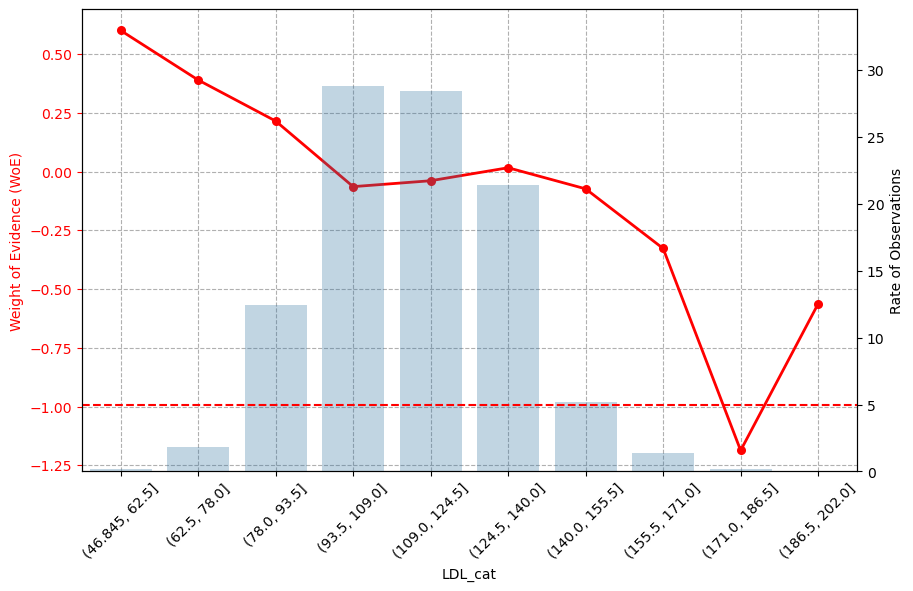

In [74]:
print_WoE(df_woe, colcat)

In [75]:
bins=[0, 90, 100, 140, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,LDL_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 90.0]",909,680,0.122810,0.096058,0.245684,1589,10.593
1,"(90.0, 100.0]",1417,875,0.158028,0.149741,0.053863,2292,15.280
2,"(100.0, 140.0]",6455,3640,0.657396,0.682130,-0.036935,10095,67.300
3,"(140.0, inf]",682,342,0.061766,0.072070,-0.154282,1024,6.827


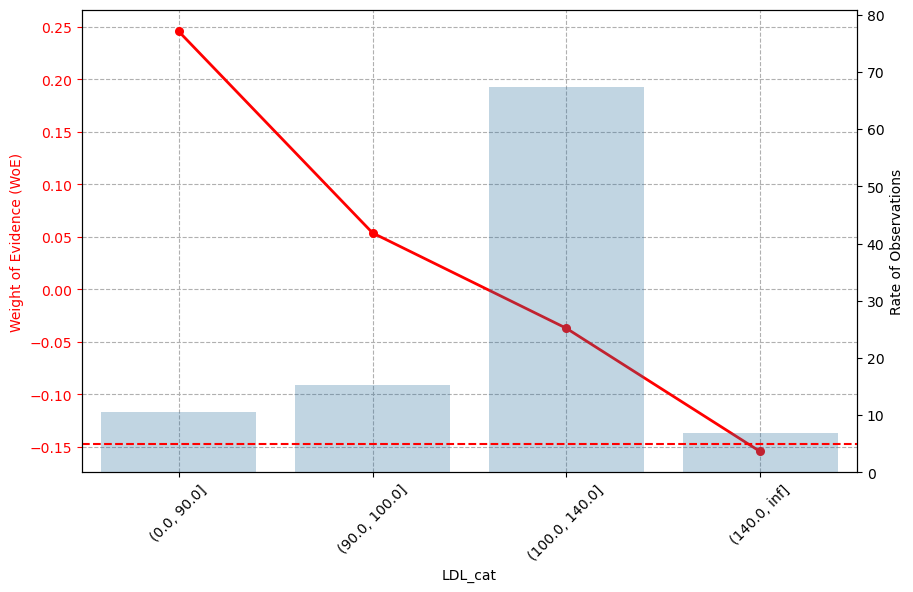

In [76]:
print_WoE(df_woe, colcat)

In [77]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### hemoglobin

In [78]:
col = 'hemoglobin'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 10)
df_woe = WoE(train, colcat)
df_woe

smoking,hemoglobin_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(7.288, 8.45]",13,0,0.000000,0.001374,-inf,13,0.087
1,"(8.45, 9.6]",53,0,0.000000,0.005601,-inf,53,0.353
2,"(9.6, 10.75]",81,1,0.000181,0.008560,-3.858513,82,0.547
3,"(10.75, 11.9]",256,1,0.000181,0.027053,-5.009241,257,1.713
4,"(11.9, 13.05]",2028,41,0.007405,0.214308,-3.365297,2069,13.793
5,"(13.05, 14.2]",3204,385,0.069532,0.338582,-1.582975,3589,23.927
6,"(14.2, 15.35]",2098,2027,0.366083,0.221706,0.501509,4125,27.500
7,"(15.35, 16.5]",1530,2622,0.473542,0.161682,1.074606,4152,27.680
8,"(16.5, 17.65]",194,436,0.078743,0.020501,1.345721,630,4.200
9,"(17.65, 18.8]",6,24,0.004334,0.000634,1.922231,30,0.200


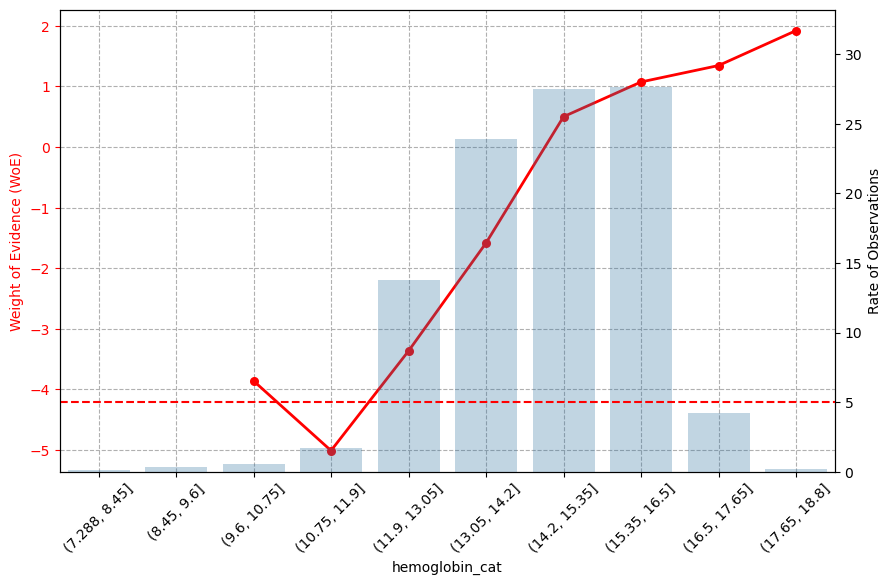

In [79]:
print_WoE(df_woe, colcat)

In [80]:
bins=[0, 12.5, 13, 13.6, 15, 16, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,hemoglobin_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 12.5]",1149,14,0.002528,0.121420,-3.871653,1163,7.753
1,"(12.5, 13.0]",1282,29,0.005237,0.135475,-3.252944,1311,8.740
2,"(13.0, 13.6]",1840,93,0.016796,0.194442,-2.448985,1933,12.887
3,"(13.6, 15.0]",2848,1620,0.292577,0.300962,-0.028254,4468,29.787
4,"(15.0, 16.0]",1765,2616,0.472458,0.186516,0.929432,4381,29.207
5,"(16.0, inf]",579,1165,0.210403,0.061186,1.235111,1744,11.627


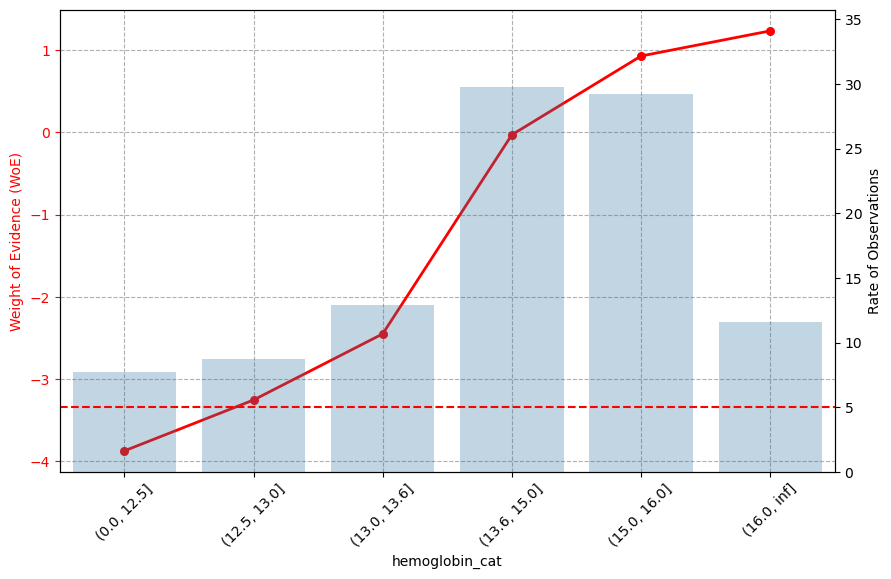

In [81]:
print_WoE(df_woe, colcat)

In [82]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### serum creatinine

In [83]:
col = 'serum creatinine'
colcat = col + '_cat'

train[colcat] = pd.cut(train[col], bins = 8)
df_woe = WoE(train, colcat)
df_woe

smoking,serum creatinine_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0986, 0.275]",0,1,0.000181,0.000000,inf,1,0.007
1,"(0.275, 0.45]",15,0,0.000000,0.001585,-inf,15,0.100
2,"(0.45, 0.625]",1497,63,0.011378,0.158195,-2.632147,1560,10.400
3,"(0.625, 0.8]",1806,265,0.047860,0.190849,-1.383203,2071,13.807
4,"(0.8, 0.975]",4073,2636,0.476070,0.430413,0.100819,6709,44.727
5,"(0.975, 1.15]",1764,2267,0.409427,0.186410,0.786810,4031,26.873
6,"(1.15, 1.325]",295,302,0.054542,0.031174,0.559388,597,3.980
7,"(1.325, 1.5]",13,3,0.000542,0.001374,-0.930400,16,0.107


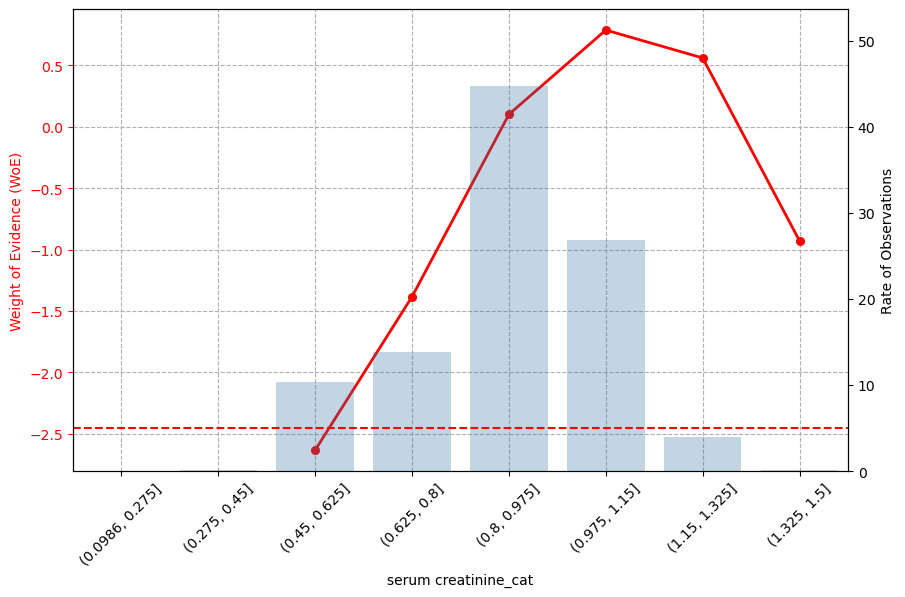

In [84]:
print_WoE(df_woe, colcat)

In [85]:
bins=[0, 0.6, 0.8, 0.9, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,serum creatinine_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 0.6]",1512,64,0.011559,0.159780,-2.626369,1576,10.507
1,"(0.6, 0.8]",4082,1221,0.220517,0.431364,-0.670980,5303,35.353
2,"(0.8, 0.9]",1797,1680,0.303413,0.189897,0.468612,3477,23.180
3,"(0.9, inf]",2072,2572,0.464511,0.218958,0.752106,4644,30.960


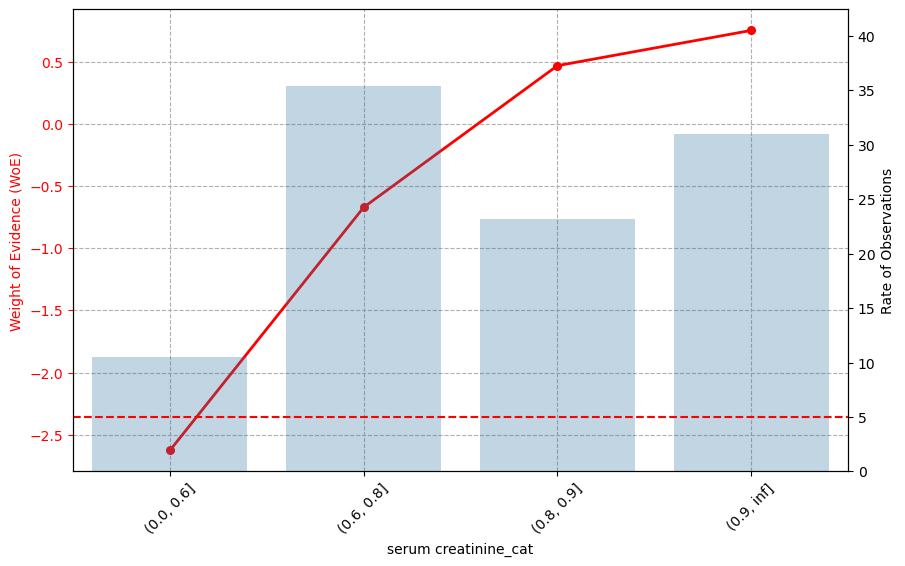

In [86]:
print_WoE(df_woe, colcat)

In [87]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### AST

In [88]:
col = 'AST'
colcat = col + '_cat'

train[colcat] = pd.qcut(train[col], q = 8)
df_woe = WoE(train, colcat)
df_woe

smoking,AST_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(9.999, 17.0]",1849,775,0.139967,0.195393,-0.333601,2624,17.493
1,"(17.0, 18.0]",773,406,0.073325,0.081687,-0.107989,1179,7.860
2,"(18.0, 20.0]",1740,935,0.168864,0.183874,-0.085157,2675,17.833
3,"(20.0, 21.0]",809,432,0.078021,0.085491,-0.091437,1241,8.273
4,"(21.0, 23.0]",1452,802,0.144844,0.153440,-0.057652,2254,15.027
5,"(23.0, 25.0]",1102,784,0.141593,0.116454,0.195464,1886,12.573
6,"(25.0, 28.0]",806,628,0.113419,0.085174,0.286393,1434,9.560
7,"(28.0, 87.0]",932,775,0.139967,0.098489,0.351467,1707,11.380


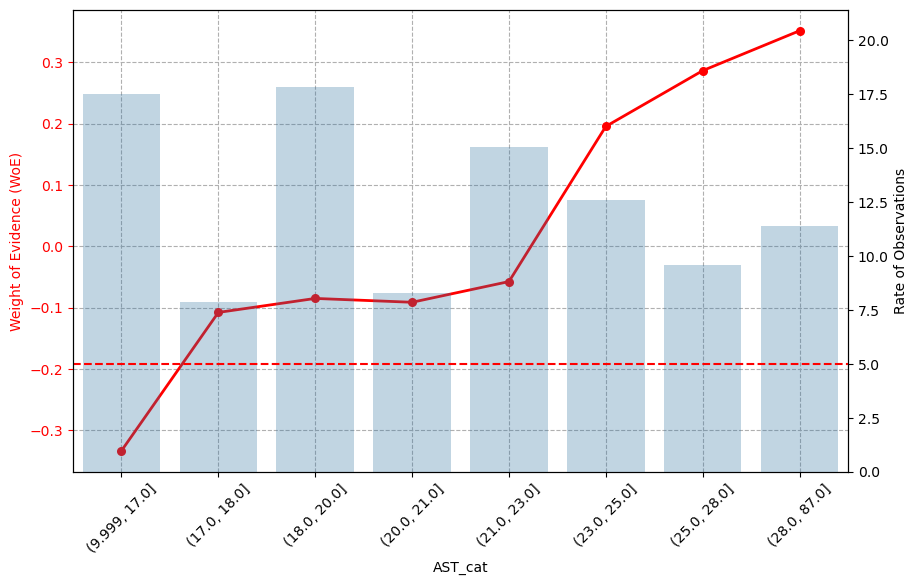

In [89]:
print_WoE(df_woe, colcat)

In [90]:
bins=[0, 16, 18, 24, 28, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,AST_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 16.0]",1134,466,0.084161,0.119835,-0.353384,1600,10.667
1,"(16.0, 18.0]",1488,715,0.129131,0.157244,-0.196969,2203,14.687
2,"(18.0, 24.0]",4562,2618,0.472819,0.482088,-0.019414,7180,47.867
3,"(24.0, 28.0]",1347,963,0.173921,0.142344,0.200355,2310,15.400
4,"(28.0, inf]",932,775,0.139967,0.098489,0.351467,1707,11.380


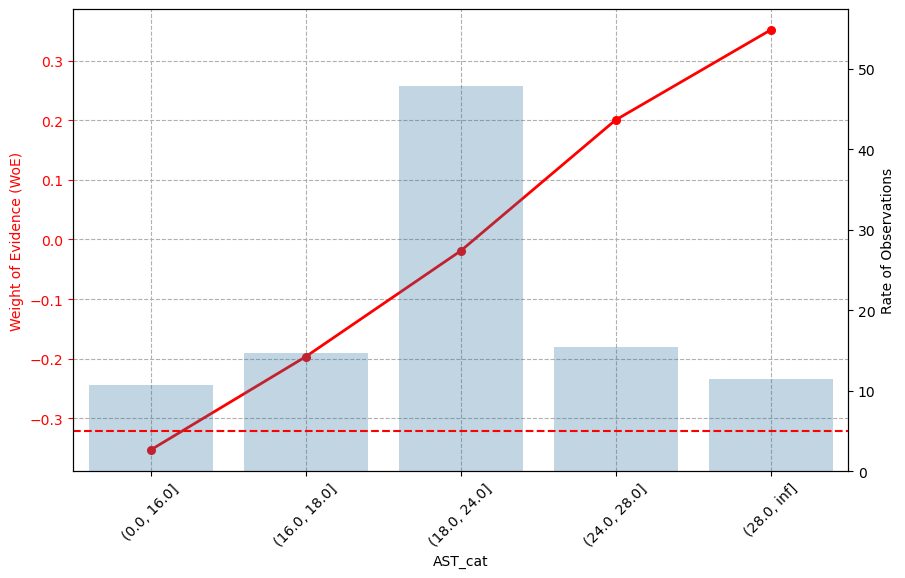

In [91]:
print_WoE(df_woe, colcat)

In [92]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### ALT

In [93]:
col = 'ALT'
colcat = col + '_cat'

train[colcat] = pd.qcut(train[col], q = 8)
df_woe = WoE(train, colcat)
df_woe

smoking,ALT_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(4.999, 12.0]",1896,338,0.061044,0.200359,-1.188519,2234,14.893
1,"(12.0, 14.0]",1330,429,0.077479,0.140547,-0.595541,1759,11.727
2,"(14.0, 16.0]",1259,629,0.113599,0.133044,-0.158005,1888,12.587
3,"(16.0, 18.0]",1243,609,0.109987,0.131354,-0.177528,1852,12.347
4,"(18.0, 21.0]",1276,860,0.155319,0.134841,0.141384,2136,14.240
5,"(21.0, 24.0]",776,702,0.126783,0.082004,0.435718,1478,9.853
6,"(24.0, 31.0]",930,911,0.164530,0.098278,0.515295,1841,12.273
7,"(31.0, 166.0]",753,1059,0.191259,0.079573,0.876952,1812,12.080


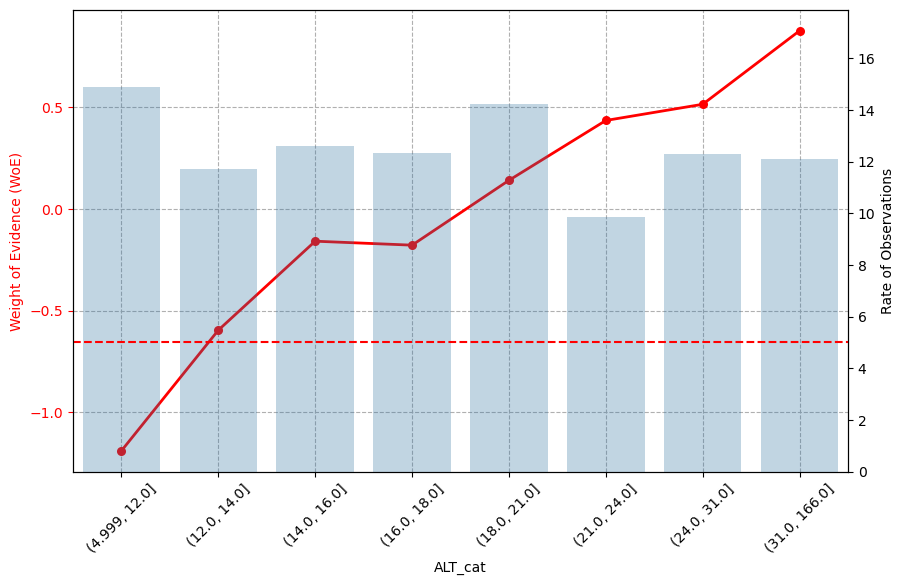

In [94]:
print_WoE(df_woe, colcat)

In [95]:
bins=[0, 12, 14, 21, 31, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,ALT_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 12.0]",1896,338,0.061044,0.200359,-1.188519,2234,14.893
1,"(12.0, 14.0]",1330,429,0.077479,0.140547,-0.595541,1759,11.727
2,"(14.0, 21.0]",3778,2098,0.378906,0.399239,-0.052274,5876,39.173
3,"(21.0, 31.0]",1706,1613,0.291313,0.180281,0.479881,3319,22.127
4,"(31.0, inf]",753,1059,0.191259,0.079573,0.876952,1812,12.080


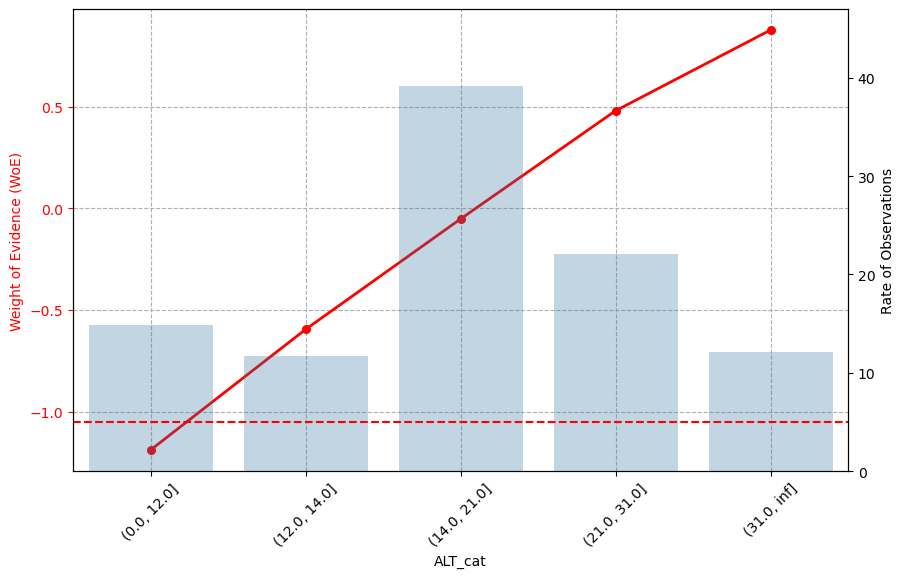

In [96]:
print_WoE(df_woe, colcat)

In [97]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

#### Gtp

In [98]:
col = 'Gtp'
colcat = col + '_cat'

train[colcat] = pd.qcut(train[col], q = 8)
df_woe = WoE(train, colcat)
df_woe

smoking,Gtp_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(5.999, 13.0]",2080,148,0.026729,0.219803,-2.106974,2228,14.853
1,"(13.0, 15.0]",1436,271,0.048943,0.151749,-1.131561,1707,11.380
2,"(15.0, 18.0]",1781,514,0.092830,0.188207,-0.706770,2295,15.300
3,"(18.0, 21.0]",1199,573,0.103486,0.126704,-0.202421,1772,11.813
4,"(21.0, 25.0]",943,654,0.118115,0.099651,0.169978,1597,10.647
5,"(25.0, 31.0]",899,898,0.162182,0.095002,0.534824,1797,11.980
6,"(31.0, 42.0]",663,1091,0.197038,0.070062,1.034012,1754,11.693
7,"(42.0, 439.0]",462,1388,0.250677,0.048822,1.635991,1850,12.333


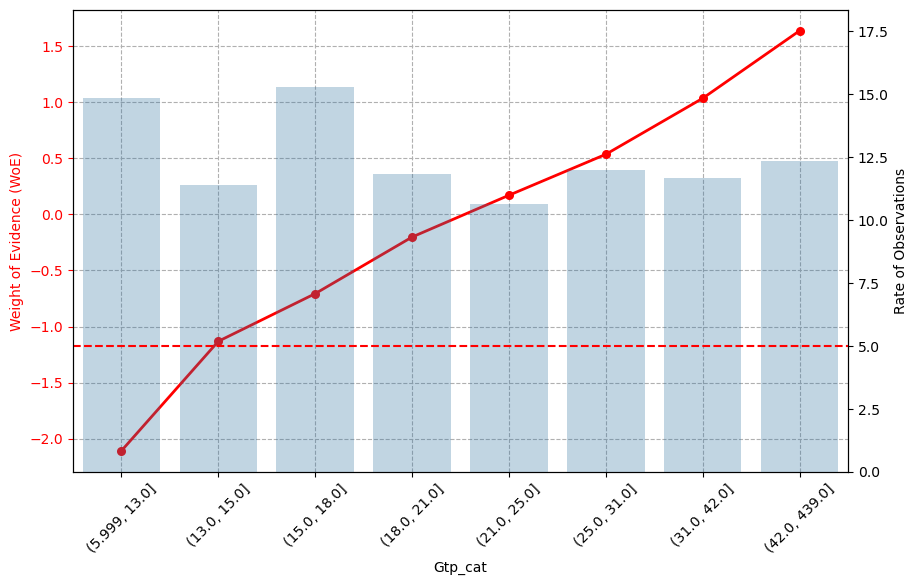

In [99]:
print_WoE(df_woe, colcat)

In [100]:
bins=[0, 13, 15, 18, 21, 25, 31, 42, np.inf]

train[colcat] = pd.cut(train[col], bins=bins)
df_woe = WoE(train, colcat)
df_woe

smoking,Gtp_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(0.0, 13.0]",2080,148,0.026729,0.219803,-2.106974,2228,14.853
1,"(13.0, 15.0]",1436,271,0.048943,0.151749,-1.131561,1707,11.380
2,"(15.0, 18.0]",1781,514,0.092830,0.188207,-0.706770,2295,15.300
3,"(18.0, 21.0]",1199,573,0.103486,0.126704,-0.202421,1772,11.813
4,"(21.0, 25.0]",943,654,0.118115,0.099651,0.169978,1597,10.647
5,"(25.0, 31.0]",899,898,0.162182,0.095002,0.534824,1797,11.980
6,"(31.0, 42.0]",663,1091,0.197038,0.070062,1.034012,1754,11.693
7,"(42.0, inf]",462,1388,0.250677,0.048822,1.635991,1850,12.333


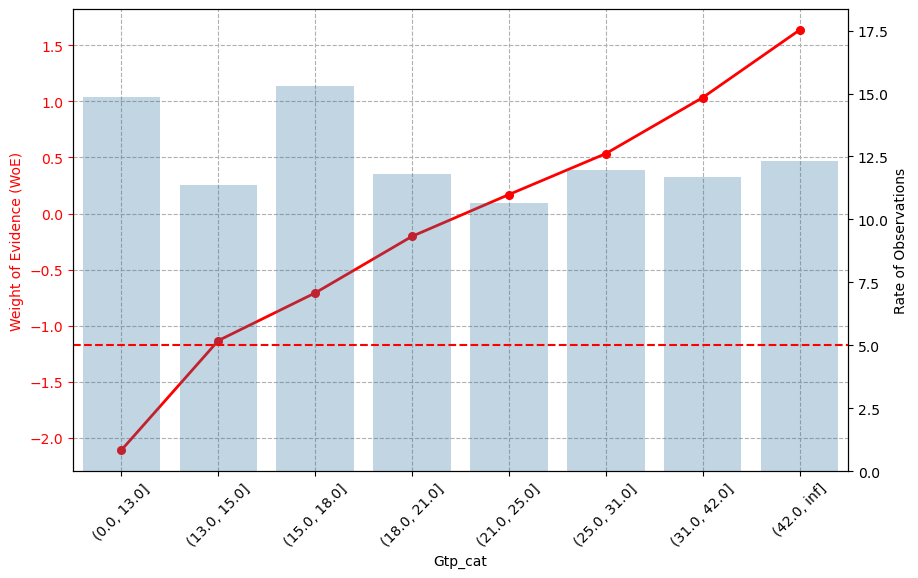

In [101]:
print_WoE(df_woe, colcat)

In [102]:
train[colcat] = train[colcat].cat.codes + 1

test[colcat] = pd.cut(test[col], bins=bins)
test[colcat] = test[colcat].cat.codes + 1

## Feature Selection

In [103]:
X = train.drop('smoking', axis=1)
y = train['smoking']

SEED = 1

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Я решил создать стэк RandomForestClassifier и LogisticRegression. FS буду делать именно под эти модели

In [104]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=SEED))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=SEED))
])

stacking_model = StackingClassifier(
    estimators=[
        ('rf_pipeline', rf_pipeline),
        ('lr_pipeline', lr_pipeline)
    ],
    final_estimator=LogisticRegression(random_state=SEED),
    cv=skf
)

In [105]:
cvs = cross_val_score(stacking_model, X, y, cv=skf, n_jobs=-1, scoring='roc_auc').mean()

np.round(cvs, 5)

0.88396

In [106]:
stacking_model.fit(X, y)

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimators=[('rf_pipeline',
                                Pipeline(steps=[('rf',
                                                 RandomForestClassifier(random_state=1))])),
                               ('lr_pipeline',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(random_state=1))]))],
                   final_estimator=LogisticRegression(random_state=1))

Признаки для RandomForest:

In [107]:
rf_model = stacking_model.named_estimators_['rf_pipeline'].named_steps['rf']


importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                    Feature  Importance
15               hemoglobin    0.091590
1                height(cm)    0.086490
23           height(cm)_cat    0.072374
12             triglyceride    0.058281
20                      Gtp    0.055434
35           hemoglobin_cat    0.041823
39                  Gtp_cat    0.041293
14                      LDL    0.034125
2                weight(kg)    0.032545
11              Cholesterol    0.032091
13                      HDL    0.030997
10      fasting blood sugar    0.030604
19                      ALT    0.029735
3                 waist(cm)    0.029542
8                  systolic    0.028276
9                relaxation    0.027155
17         serum creatinine    0.027130
18                      AST    0.027057
0                       age    0.023710
24           weight(kg)_cat    0.018641
32         triglyceride_cat    0.018225
5           eyesight(right)    0.016766
36     serum creatinine_cat    0.016552
4            eyesight(left)    0.015817


Признаки для Logistic Regression:

In [108]:
lr_model = stacking_model.named_estimators_['lr_pipeline'].named_steps['lr']

coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

                    Feature  Coefficient
23           height(cm)_cat     0.952044
15               hemoglobin     0.808494
39                  Gtp_cat     0.607109
20                      Gtp     0.272714
1                height(cm)     0.225585
12             triglyceride     0.206564
21            dental caries     0.198366
32         triglyceride_cat     0.139100
22                  age_cat     0.118098
29           relaxation_cat     0.113088
36     serum creatinine_cat     0.112704
27      eyesight(right)_cat     0.098460
26       eyesight(left)_cat     0.096804
3                 waist(cm)     0.033095
0                       age     0.022255
24           weight(kg)_cat     0.007339
10      fasting blood sugar     0.003597
6             hearing(left)     0.000000
7            hearing(right)     0.000000
31          Cholesterol_cat    -0.002076
30  fasting blood sugar_cat    -0.002221
11              Cholesterol    -0.018235
18                      AST    -0.033433
35           hem

Посмотрел на верхние результаты и, после некоторых экспериментов, выбрал вот эти признаки:

## 1

In [ ]:
features = X.columns.to_list()


def objective(trial):
    selected_features = [
        feature for feature in features if trial.suggest_categorical(feature, [True, False])
    ]
    
    X_selected = X[selected_features]

    rf_pipeline = Pipeline([
        ('rf', RandomForestClassifier(
            criterion='entropy', n_estimators=200, max_depth=14,
            min_samples_split=5, min_samples_leaf=8, max_features=4,
            random_state=SEED))
    ])
    
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('lr', LogisticRegression(C=0.05, max_iter=150, random_state=SEED))
    ])
    
    stacking_model = StackingClassifier(
        estimators=[
            ('rf_pipeline', rf_pipeline),
            ('lr_pipeline', lr_pipeline)
        ],
        final_estimator=LogisticRegression(C=0.1, max_iter=100, random_state=SEED),
        cv=skf
    )
    
    score = cross_val_score(stacking_model, X_selected, y, cv=skf, scoring="roc_auc").mean()
    
    return score

study = optuna.create_study(
    storage='sqlite:///optuna.db',
    study_name='First study',
    load_if_exists=True,
    direction='maximize'
)

study.optimize(objective, n_trials=100)

best_features = [feature for feature in features if study.best_trial.params[feature]]
print("Лучшие признаки для модели:", best_features)

In [ ]:
columns = [
    'age',
    'age_cat',
    'height(cm)',
    'height(cm)_cat',
    'weight(kg)_cat',
    'waist(cm)',
    'waist(cm)_cat',
    'eyesight(right)',
    'eyesight(right)_cat',
    'systolic',
    'fasting blood sugar_cat',
    'Cholesterol',
    'triglyceride',
    'LDL',
    'hemoglobin',
    'hemoglobin_cat',
    'serum creatinine',
    'serum creatinine_cat',
    'AST',
    'ALT',
    'Gtp',
    'dental caries'
]

X = X[columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

## HPO

In [111]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 15)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 15)
    rf_max_features = trial.suggest_int('rf_max_features', 4, 20)

    rf_pipeline = Pipeline([
        ('rf', RandomForestClassifier(
            criterion='entropy',
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
            min_samples_leaf=rf_min_samples_leaf,
            max_features=rf_max_features,
            random_state=SEED
        ))
    ])

    lr_C = trial.suggest_loguniform('lr_C', 1e-4, 1e1)
    
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('lr', LogisticRegression(C=lr_C, random_state=SEED))
    ])

    lr_C_2 = trial.suggest_loguniform('lr_C_2', 1e-4, 1e1)
    
    stacking_model = StackingClassifier(
        estimators=[
            ('rf_pipeline', rf_pipeline),
            ('lr_pipeline', lr_pipeline)
        ],
        final_estimator=LogisticRegression(C=lr_C_2, random_state=SEED),
        cv=skf
    )

    train_score = cross_val_score(stacking_model, X_train, y_train, cv=skf, n_jobs=-1, scoring='roc_auc').mean()
    test_score = cross_val_score(stacking_model, X_test, y_test, cv=skf, n_jobs=-1, scoring='roc_auc').mean()
    
    # Минимизация разницы между обучением и тестом для уменьшения переобучения
    difference = abs(train_score - test_score)
    score = test_score - difference
    
    return score

study = optuna.create_study(
    storage='sqlite:///optuna.db',
    study_name='My study',
    load_if_exists=True,
    direction='maximize'
)

study.optimize(objective, n_trials=10)

trial = study.best_trial

print("Best trial:")
print(f"Value: {trial.value}")
print("Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-10-31 14:44:52,406] Using an existing study with name 'My study' instead of creating a new one.
[I 2024-10-31 14:46:13,952] Trial 110 finished with value: 0.8823718359057857 and parameters: {'rf_max_depth': 15, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 2, 'rf_max_features': 10, 'lr_C': 0.003544897247629506, 'lr_C_2': 7.430982213085463}. Best is trial 53 with value: 0.8846829143196233.
[I 2024-10-31 14:47:47,093] Trial 111 finished with value: 0.8841664419084365 and parameters: {'rf_max_depth': 14, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3, 'rf_max_features': 9, 'lr_C': 0.0064899787471980434, 'lr_C_2': 1.4560231159881554}. Best is trial 53 with value: 0.8846829143196233.
[W 2024-10-31 14:48:41,422] Trial 112 failed with parameters: {'rf_max_depth': 15, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 3, 'rf_max_features': 9, 'lr_C': 0.0076426475028783785, 'lr_C_2': 1.6214729339150484} because of the following error: KeyboardInterrupt().
Traceback (most recent

KeyboardInterrupt: 

Глянем какие параметры влияли а какие нет

In [ ]:
vis.plot_param_importances(study).show()

In [ ]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(criterion='entropy',
                                  max_depth=14,
                                  min_samples_split=8,
                                  min_samples_leaf=2,
                                  max_features=7,
                                  random_state=SEED))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr', LogisticRegression(C=0.02, random_state=SEED))
])

stacking_model = StackingClassifier(
    estimators=[
        ('rf_pipeline', rf_pipeline),
        ('lr_pipeline', lr_pipeline)
    ],
    final_estimator=LogisticRegression(C=6.45, random_state=SEED),
    cv=skf
)

## Learning curve

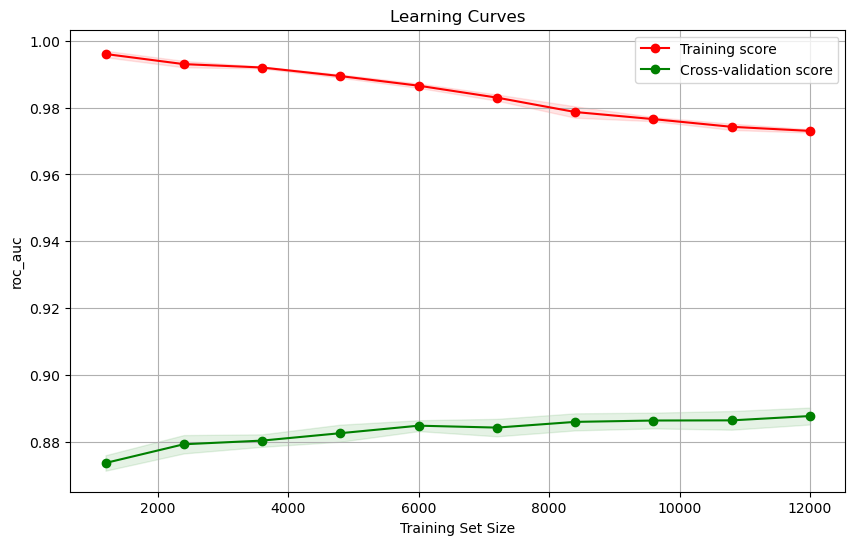

In [ ]:
def plot_learning_curves(estimator, X, y, scoring='roc_auc', cv=skf):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.xlabel('Training Set Size')
    plt.ylabel(scoring)
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curves(stacking_model, X, y)


По мере увеличения размера датасета модель работает лучше и тенденция сохроняется. Следовательно можно воспользоваться всеми данными для обучения

## Calibration

In [ ]:
def plot_calibration_curve(y_true, y_probs_list, labels, title):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='gray')
    for y_prob, label in zip(y_probs_list, labels):
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
        plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.title(title)
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Brier Score (Def): 0.1268
Brier Score (Sigmoid): 0.1268
Brier Score (Isotonic): 0.1264


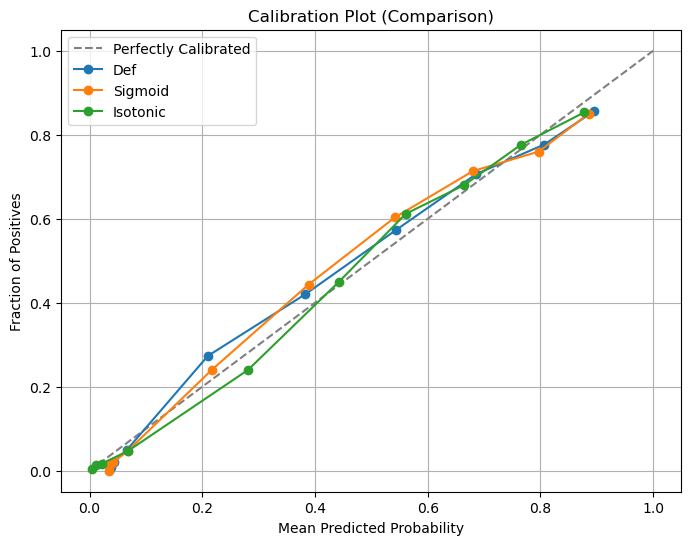

In [ ]:
stacking_model.fit(X_train[columns], y_train)
y_prob = stacking_model.predict_proba(X_test[columns])[:,1]
brier_def = brier_score_loss(y_test, y_prob)
print(f"Brier Score (Def): {brier_def:.4f}")

rf_sigmoid = CalibratedClassifierCV(stacking_model, method='sigmoid', cv=skf, n_jobs=-1)
rf_sigmoid.fit(X_train, y_train)
y_prob_sigmoid = rf_sigmoid.predict_proba(X_test)[:,1]
brier_sigmoid = brier_score_loss(y_test, y_prob_sigmoid)
print(f"Brier Score (Sigmoid): {brier_sigmoid:.4f}")

rf_isotonic = CalibratedClassifierCV(stacking_model, method='isotonic', cv=skf, n_jobs=-1)
rf_isotonic.fit(X_train, y_train)
y_prob_isotonic = rf_isotonic.predict_proba(X_test)[:,1]
brier_isotonic = brier_score_loss(y_test, y_prob_isotonic)
print(f"Brier Score (Isotonic): {brier_isotonic:.4f}")

plot_calibration_curve(
    y_test,
    [y_prob, y_prob_sigmoid, y_prob_isotonic],
    ['Def', 'Sigmoid', 'Isotonic'],
    'Calibration Plot (Comparison)'
)

In [ ]:
print('ROC-AUC (def)     ', round(roc_auc_score(y_test, y_prob),5))
print('ROC-AUC (sigmoid) ', round(roc_auc_score(y_test, y_prob_sigmoid),5))
print('ROC-AUC (isotonic)', round(roc_auc_score(y_test, y_prob_isotonic),5))

ROC-AUC (def)      0.89425
ROC-AUC (sigmoid)  0.89379
ROC-AUC (isotonic) 0.89344


## Save

In [ ]:
train.to_csv('train_2.csv', index=False)
test.to_csv('test_2.csv', index=False)